# Chlorophyll A Data Vis Workbook
### Amy Phung, March 2020

## Setup, Imports, & Globals

### Imports

In [1]:
%matplotlib inline
import os
import scipy
import scipy.signal
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import netCDF4
import itertools
import datetime
from jupyterthemes import jtplot
import matplotlib as mpl
import cartopy.feature
import cartopy.crs as ccrs
import timeit
from sklearn.mixture import GaussianMixture
from matplotlib.ticker import PercentFormatter

### Setup

In [2]:
# Uncomment for dark graphs
# jtplot.style(theme="oceans16", context="notebook", ticks=True, grid=False)

# Uncomment for white-background figures
mpl.rcParams['figure.facecolor'] = 'white'

# Make graphs appear larger
plt.rcParams['figure.dpi'] = 200

# Change font
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

# Uncomment to change pandas display options
# pd.set_option('display.max_rows', 60)
# pd.set_option('display.max_columns', 30)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

### Globals

In [3]:
STD_COLUMN_NAMES = ["Src", "Lat", "Long", "Chl-A", "Timestamp", 
                    "Station"]
SAT_COLUMN_NAMES = ["Filename", "Sat Lat", "Sat Long", "Sat Chl-A",
                   "Lat Error", "Long Error", "Time Error"]

## Helper Classes

In [4]:
# Best fit line
class BestFitLine:
    def __init__(self, x, y):
        self.slope, self.intercept, self.r_value, self.p_value, \
            self.std_err = scipy.stats.linregress(x, y)
    
    def computeY(self, x):
        return self.intercept + self.slope*x

## Data Classes

### Main Class

In [5]:
class Dataset:
    """
    Class for datasets with methods to process and reformat raw data
    
    Attributes:
        _source (str): String representing where data came from
        _cols (dict): Dictionary containing lookup for raw column names
        _raw_df (DataFrame): Pandas dataframe containing raw csv data
        df (DataFrame): Pandas dataframe containing formatted data
    """
    def __init__(self, filename, source, column_names):
        self._filename = filename
        self._source = source
        self._cols = column_names
        
    def _loadRaw(self):
        return pd.read_csv(self._filename)
        
    def _processRaw(self):
        pass
    
    def _parseDate(self):
        """ Convert an unformatted timestamp in raw dataset to a Python 
        datetime then to a timestamp. Returns timestamp """
        pass
    
    def _formatData(self, df):
        """Copy relevant data from a specified dataframe to a new 
        dataframe
        
        Args:
            df (DataFrame): Pandas dataframe to copy data from
        """
        
        self.df["Src"] = self._source
        self.df["Lat"] = df[self._cols["Lat"]]
        self.df["Long"] = df[self._cols["Long"]]
        self.df["Chl-A"] = df[self._cols["Chl-A"]]
        self.df["Timestamp"] = df[self._cols["Time"]]
        self.df["Station"] = df[self._cols["Station"]]

### BGC Class

In [6]:
class DatasetBGC(Dataset):
    def __init__(self, filename, source, column_names):
        Dataset.__init__(self, filename, source, column_names)
        self._raw_df = self._loadRaw()
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                               columns=STD_COLUMN_NAMES)
        self._formatData(self._raw_df)
        
    def _processRaw(self):
        # Remove unused columns
        self._raw_df.dropna(axis=1, how='all', inplace=True) 
        # Drop points missing chlorophyll values
        self._raw_df.dropna(inplace=True) 
        # Drop duplicates (for some reason stations 1-9 like to duplicate)
        self._raw_df.drop_duplicates(inplace=True) 
        # Add in column with station numbers
        self._raw_df["Station Num"] = range(1, len(self._raw_df)+1) 
        # Normalize chlorophyll data
        self._raw_df[self._cols["Chl-A"]] = \
            self._raw_df[self._cols["Chl-A"]]/20. 
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        # Reset dataframe index
        self._raw_df.reset_index(inplace=True)
        
    def _parseDate(self, df_row):
        time_str = df_row["yyyy-mm-ddThh:mm:ss.sss"]
        year   = int(time_str[0:4])
        month  = int(time_str[5:7])
        day    = int(time_str[8:10])
        hour   = int(time_str[11:13])
        minute = int(time_str[14:16])
        second = int(time_str[17:19])
        
        date = datetime.datetime(year, month, day, hour, minute, second)
        timestamp = datetime.datetime.timestamp(date)
        return timestamp

### HC Class

In [7]:
class DatasetHC(Dataset):
    def __init__(self, filename, source, column_names):
        self._best_fit_line = None
        self._cal_df = None
        Dataset.__init__(self, filename, source, column_names)

        self._raw_df = self._loadRaw()
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                               columns=STD_COLUMN_NAMES)
        self._formatData(self._raw_df)
        
    def _loadRaw(self):
        """Hydrocast data needs tab delimiter and header skipping"""
        # To get data from ODV:
        # Export>Station Data>ODV Spreadsheet file>Uncheck all exports
        return pd.read_csv(self._filename, delimiter="\t",header=27)
        
    def _processRaw(self):
        # Fill in cruise, station, type, date, lat, long, bottom depth 
        # with most recent values
        col_to_fill = ["Cruise", 
                       "Station",
                       "Type",
                       "yyyy-mm-ddThh:mm:ss.sss",
                       "Longitude [degrees_east]",
                       "Latitude [degrees_north]",
                       "Bot. Depth [m]"]
        
        for col in col_to_fill: self._raw_df[col].fillna(method="pad", 
                                                         inplace=True)
        # Add in column with station numbers as integers
        self._raw_df["Station Num"] = \
            self._raw_df["Station"].apply(self._getStationNum) 
        # Add in column with corrected timestamps
        self._raw_df["Corrected Timestamp"] = \
            self._raw_df["yyyy-mm-ddThh:mm:ss.sss"].apply(self._correctHCTimestamp)
        # Only keep points with valid Chl-A fluorescence measurements
        self._raw_df.dropna(subset=["Chl a Fluorescence [V]"], inplace=True)
        # Compute best fit line for calibrated Chl-A data
        self._best_fit_line, self._cal_df = self._calibrateData()
        # Apply best fit line to full dataset
        self._raw_df["Calculated Chl-A"] = \
            self._raw_df["Chl a Fluorescence [V]"].apply( \
            self._best_fit_line.computeY)
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        # Reset dataframe index
        self._raw_df.reset_index(inplace=True)
    
    def _parseDate(self, df_row):
        time_str = df_row["Corrected Timestamp"]
        year   = int(time_str[0:4])
        month  = int(time_str[5:7])
        day    = int(time_str[8:10])
        hour   = int(time_str[11:13])
        minute = int(time_str[14:16])
        
        date = datetime.datetime(year, month, day, hour, minute)
        timestamp = datetime.datetime.timestamp(date)
        return timestamp
    
    def _formatData(self, df):
        """Hydrocast data has additional depth column to add to dataset"""
        self.df["Src"] = self._source
        self.df["Lat"] = df[self._cols["Lat"]]
        self.df["Long"] = df[self._cols["Long"]]
        self.df["Chl-A"] = df[self._cols["Chl-A"]]
        self.df["Timestamp"] = df[self._cols["Time"]]
        self.df["Station"] = df[self._cols["Station"]]
        self.df["Depth"] = df["Depth [m]"]
        
    # Other Functions
    def _getStationNum(self, station_name):
        """Parses station name from hydrocast dataset and returns an int 
        representing station number.

        Args:
            station_name (str): Hydrocast station name in the format S290-###-HC

        Returns:
            station_num (int): Hydrocast station number
        """
        return int(station_name[5:8])
    
    def _correctHCTimestamp(self, timestamp):
        """Applies correction to HC timestamp - 2020 is incorrectly written as
        0020, so this function returns a new timestamp in the correct format

        Args:
            timestamp (str): Incorrect timestamp from hydrocast data

        Returns:
            corrected_timestamp (str): Corrected timestamp
        """
        new_timestamp = "2020" + timestamp[4:]
        return new_timestamp
        
    def _calibrateData(self):
        """Computes best fit line between fluorescence and Chl-A value
        for hydrocast data"""
        # Create calibration dataset
        cal_df = self._raw_df.dropna(subset=["Chl-a [ug/L]"])
        # Compute best fit line
        hc_fit_line = BestFitLine(cal_df["Chl a Fluorescence [V]"],
                                  cal_df["Chl-a [ug/L]"])
        return hc_fit_line, cal_df
    
    # Visualizations
    def visualizeCalibration(self):
        plt.scatter(self._cal_df["Chl a Fluorescence [V]"], 
                    self._cal_df["Chl-a [ug/L]"], 
                    c=self._cal_df["Depth [m]"],
                    marker='.')
        plt.colorbar(label="Depth [m]")
        plt.xlabel("Chl-a Fluorescence [V]")
        plt.ylabel("Chl-a [ug/L]")

        xp = np.linspace(self._cal_df["Chl a Fluorescence [V]"].min(),
                         self._cal_df["Chl a Fluorescence [V]"].max(),
                         100)
        eq = "y = " + str(round(self._best_fit_line.slope,2)) + \
             "x + " + str(round(self._best_fit_line.intercept,2))
        
        plt.plot(xp, self._best_fit_line.computeY(xp), label=eq)
        plt.legend()

        

### Flow-through Class

In [8]:
class DatasetFT(Dataset):
    """
    Class for flow-through data

    Attributes:
        hc_df (DataFrame): Pandas dataframe containing calibrated
            hydrocast data to use for FT calibration
        ports (dict): Dictionary containing start and end timestamps
            in UTC of port stops
        ml_depth (int): mixed layer depth - determines which hydrocast 
            points can be included in calibration set
        median_pts (int): number of points to include in median filter.
            Use 1 to disable filter
    """
    def __init__(self, filename, source, column_names, hc_df, ports,
                 ml_depth=25, median_pts=1):
        self._hc_df = hc_df
        self._ports = ports
        self._ml_depth = ml_depth
        self._median_pts = median_pts
        Dataset.__init__(self, filename, source, column_names)
        self._raw_df = self._loadRaw()
        
        # Save copies for graphing
        self.port_df = None
        self.port_filtered_df = None
        self.median_filtered_df = None

        self._best_fit_line = None
        self._cal_df = None
        
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self.median_filtered_df)),
                       columns=STD_COLUMN_NAMES)
        self._formatData(self.median_filtered_df)

    def _processRaw(self):
        # Drop points without fluorescence values
        self._raw_df.dropna(subset=["Fluor-Chl-avg-1-min-Value"], inplace=True)
        # Add in column with properly formatted latitude
        self._raw_df["Latitude"] = \
            self._raw_df["GPS-nav-Lat"].apply(self._computeDegreesDecimalFT)
        # Add in column with properly formatted longitude
        self._raw_df["Longitude"] = \
            self._raw_df["GPS-nav-Lon"].apply(self._computeDegreesDecimalFT)
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        # Add in column with station numbers
        self._raw_df["Station Num"] = range(1, len(self._raw_df) + 1)
        # Reset dataframe index
        self._raw_df.reset_index(inplace=True)

        # Save data from port stops
        port_bool = self._getPortBoolArray(self._raw_df)
        self.port_df = self._raw_df[port_bool]
        # Save data without port stops
        self.port_filtered_df = self._raw_df[np.invert(port_bool)]
        # Save data without outliers
        out_bool = self._getOutlierBoolArray(self.port_filtered_df)
        self.outlier_filtered_df = self.port_filtered_df[np.invert(out_bool)]
        # Save median filtered data
        self.median_filtered_df = self.outlier_filtered_df.copy()
        self.median_filtered_df.reset_index(inplace=True)
        self._computeMedianFilter(self.outlier_filtered_df)    
        
        # Compute best fit line
        self._best_fit_line, self._cal_df = self._calibrateData()
        # Apply best fit line to data
        self.median_filtered_df["Calculated Chl-A"] = \
            self.median_filtered_df["Fluor-Chl-avg-1-min-Value"].apply(self._best_fit_line.computeY)
    
    def _parseDate(self, df_row):
        date = df_row["Date"]
        time = df_row["Time"]
        
        year   = int(date[6:10])
        month  = int(date[0:2])
        day    = int(date[3:5])
        hour   = int(time[0:2])
        minute = int(time[3:5])
        second = int(time[6:8])

        date = datetime.datetime(year, month, day, hour, minute, second)
        timestamp = datetime.datetime.timestamp(date)
        return timestamp
    
    # Calibration
    def _calibrateData(self):
        """Computes best fit line between fluorescence and Chl-A value
        for flow-through data
            
        Returns:
            ft_fit_line (BestFitLine): best fit line function
            cal_df (DataFrame): calibration dataset - flow through & 
                corresponding hydrocast points
        """
        # Initialize empty calibration dataframe
        cal_col = list(self._hc_df.columns) \
                  + ["FT Timestamp", "FT Chlorophyll", 
                     "Time Delta", "FT Station"]
        cal_df = pd.DataFrame(index=range(0,len(self._hc_df)), \
                                    columns=cal_col)
        # Fill in data from hydrocast
        cal_df.update(self._hc_df)
        # Filter out data outside mixed layer depth
        cal_df = cal_df[cal_df["Depth"] <= self._ml_depth]
        cal_df.reset_index(inplace=True)
        # Lookup nearest flow-through point
        cal_df[["FT Timestamp", "FT Chlorophyll", 
                "Time Delta", "FT Station"]] = \
            cal_df.apply(self._lookupNearestPt, axis=1)
        # Compute best fit line
        ft_fit_line = BestFitLine(cal_df["FT Chlorophyll"][cal_df["FT Chlorophyll"]<8].astype(float),
                                  cal_df["Chl-A"][cal_df["FT Chlorophyll"]<8].astype(float))
        return ft_fit_line, cal_df

    def _lookupNearestPt(self, df_row):
        deltas = abs(df_row["Timestamp"] - self.median_filtered_df["Timestamp"])
        nearest_idx = deltas.argmin()
        
        timestamp = self.median_filtered_df["Timestamp"][nearest_idx]
        chl = self.median_filtered_df["Fluor-Chl-avg-1-min-Value"][nearest_idx]
        delta = deltas.min()
        station = self.median_filtered_df["Station Num"][nearest_idx]
        return pd.Series([timestamp, chl, delta, station])
    
    
    
    # Other Functions
    def _computeDegreesDecimalFT(self, gps_val):
        """Converts latitude or longitude value from flow-through dataset
        into a compatible numerical value. 
        Example input values:
            3650.1777S = 36 degrees, 50.1777 minutes South
            4136.8718S = 41 degrees, 36.8718 minutes South
            17446.9143E = 174 degrees, 46.9143 minutes East
            17959.6199W = 179 degrees, 59.6199 minutes West

        Args:
            gps_val (str): Input latitude or longitude value to be converted

        Output:
            gps_num (float): GPS input value in decimal form. Latitude range
                [-90, 90], Longitude range [0, 360]
        """
        dec_idx = gps_val.find(".") 
        degrees = int(gps_val[:dec_idx-2]) # Degrees
        minutes = float(gps_val[dec_idx-2:dec_idx+4]) # Minutes
        decimal = minutes/60.

        gps_num = degrees + decimal

        if gps_val[-1] == "S":
            gps_num = (gps_num*-1) 
        elif gps_val[-1] == "W":
            gps_num = (gps_num*-1) % 360 # Convert from [-180 180] to [0 360]

        return gps_num
    
    # Filter functions    
    def _getPortBoolArray(self, df):
        """Computes a bool array highlighting points with timestamps 
        within the specified dictionary
        
        Args:
            df (DataFrame): Pandas dataframe to filter
        Returns:
            output (np bool array): whether a point was recorded during 
                a port stop
        """
        dates = self._ports.values() 
        output = np.zeros(len(df),dtype=bool)
        
        for date in dates:
            port_pts = (df["Timestamp"]>=date[0].timestamp()) & \
                       (df["Timestamp"]<=date[1].timestamp())
            
            output = output | port_pts
        return output
    
    def _getOutlierBoolArray(self, df):
        """Computes a bool array highlighting outliers (points more 
        than 3 sigma from the mean)
        
        Args:
            df (DataFrame): Pandas dataframe to filter
        Returns:
            output (np bool array): whether a point is an outlier or not
        """
        measurements = np.array(df["Fluor-Chl-avg-1-min-Value"])
        
        mean = np.mean(measurements, axis=0)
        sd = np.std(measurements, axis=0)

        output = (measurements < mean - 3 * sd) | \
                 (measurements > mean + 3 * sd)    
        
        return output
    
    def _computeMedianFilter(self, df):
        """Compute median filter points and saves points in 
        median filtered dataframe
        
        Args:
            df (DataFrame): Pandas dataframe containing points to apply 
                filter to
        """
        
        measurements = np.array(df["Fluor-Chl-avg-1-min-Value"])
        pts = scipy.signal.medfilt(measurements, self._median_pts)
        
        self.median_filtered_df["Fluor-Chl-avg-1-min-Value"] = pd.Series(pts)
    
    # Visualizations
    def visualizeCalibration(self):
        plt.scatter(self._cal_df[self._cal_df["FT Chlorophyll"]<8]["FT Chlorophyll"], 
                    self._cal_df[self._cal_df["FT Chlorophyll"]<8]["Chl-A"], 
                    marker='.')
    
        plt.xlabel("Flow-Through Chl-a Fluorescence [V]")
        plt.ylabel("Hydrocast Chl-a [ug/L]")

        xp = np.linspace(self._cal_df["FT Chlorophyll"].min(),
                         self._cal_df["FT Chlorophyll"].max(),
                         100)
        eq = "y = " + str(round(self._best_fit_line.slope,2)) + \
             "x + " + str(round(self._best_fit_line.intercept,2))
        plt.plot(xp, self._best_fit_line.computeY(xp), label=eq)
        
        plt.legend()

### Satellite Class

In [9]:
class DatasetSat:
    def __init__(self, directory, 
                 csv_dir="data/satellite-data/autogenerated-csv\\",
                 downsample=1000):
        self._directory = directory
        self._csv_dir = csv_dir
        self.downsample = downsample
        self.lookup_df = self._createLookupTable()
        self._active_df = None
            
    def _createLookupTable(self):
        """Creates lookup table for finding appropriate file by time"""
        csv_list = glob.glob('%s/*.csv' % self._csv_dir)
        l_df = pd.DataFrame(columns=["Filename", "Time Start", "Time End"])
        l_df["Filename"] = csv_list
        l_df[["Time Start", "Time End"]] = \
            l_df["Filename"].apply(self._fillTimestamps)
        display(l_df)
        return l_df
            
    def _fillTimestamps(self, f):
        year_st, day_st, year_end, day_end = self._parseFilenameDate(f)
        time_st = datetime.datetime(year_st, 1, 1) \
                  + datetime.timedelta(day_st - 1)
        time_end = datetime.datetime(year_end, 1, 1) \
                  + datetime.timedelta(day_end)
        return pd.Series([time_st.timestamp(), time_end.timestamp()])     
    
    def _loadSatelliteData(self, filename):
        """Loads csv file with satellite data into a dataframe

        Args:
            filename (str): string representing file location of csv 
                file with satellite data
                
        Returns:
            sat_df (DataFrame): pandas dataframe containing satellite data
        """ 
        print("Loading file " + filename + "...")

        # Downsample
        num_lines = sum(1 for l in open(filename)) # count lines
        skip_idx = [x for x in range(1, num_lines) if x % self.downsample != 0]

        sat_df = pd.read_csv(filename, skiprows=skip_idx)

        return sat_df
    
    # Public functions
    def convertSatelliteData(self):
        """Converts all .nc satellite data files in directory to .csv files. 
        First checks if file has already been converted

        Args:
            save_dir (str): directory to save output .csv files
        """
        # Iterate through files in sat_data_dir
        for f in glob.glob('%s/*.nc' % self._directory): 
            if self._checkIfConverted(f, self._csv_dir):
                print(f + " is already converted. Skipping file...")
            else:
                print("Converting " + f + "...")
                self._convertNCtoCSV(f, self._csv_dir)
    
    def findBestFile(self, timestamp):
        """For a given timestamp, finds the best satellite data file"""

        valid_st = self.lookup_df[(timestamp >= self.lookup_df["Time Start"])]
        if len(valid_st) == 0: # Timestamp is earlier than available data
#             print("Warning: Timestamp is earlier than available data. Using first available file")
            return str(self.lookup_df.iloc[0]["Filename"])
        
        valid_end = valid_st[timestamp < valid_st["Time End"]]
        if len(valid_end) == 0: # Timestamp is later than available data
#             print("Warning: Timestamp is later than available data. Using last available file")
            return str(self.lookup_df.iloc[-1]["Filename"])
        
        return str(valid_end.iloc[-1]["Filename"])
    
    def lookupChlorophyll(self, df_row, 
                          lat_col="Lat", long_col = "Long"):
        """Looks up nearest point and returns the corresponding 
        chlorophyll value
        
        Assumes correct satellite data file has already been loaded into 
        the active dataframe.
        
        Args:
            df_row (Series): Pandas series containing row of data with 
                latitude and longitude values to look up
            lat_col (str): String representing column of df_row to use
                for latitude
            long_col (str): String representing column of df_row to use
                for longitude
                
        Returns:
            output (Series): Pandas series containing:
                chl_A_value (float): Chlorophyll value of the nearest 
                    satellite data point to input point
                nearest_lat (float): Latitiude of nearest data point
                nearest_long (float): Longitude of nearest data point
        """
        lat = df_row[lat_col]
        long = df_row[long_col]
        nearest_sat_df = self.findNearestPoint(lat, long, self._active_df)
    
        chl_A_value = nearest_sat_df["Chlorophyll"]
        nearest_lat = nearest_sat_df["Latitude"]
        nearest_long = nearest_sat_df["Longitude"]

        output = pd.Series({"Sat Chl-A": float(chl_A_value), 
                            "Sat Lat":   float(nearest_lat), 
                            "Sat Long":  float(nearest_long)})
        return output
        
    def setActiveFrame(self, filename):
        """Loads in csv file specified and sets it as the active dataframe
        """
        self._active_df = self._loadSatelliteData(filename)
        
    # Helper functions for NC to CSV file conversion
    def _checkIfConverted(self, filename, save_dir):
        """Checks to see if .nc file has already been converted to a .csv file

        Args:
            filename (str): string representing file location of satellite data 
                file (.nc format)
            save_dir (str): directory to save output .csv files

        Returns:
            is_converted (bool): whether the corresponding .csv file exists for 
                the input .nc file
        """
        csv_list = glob.glob('%s/*.csv' % save_dir)
        expected_filename = save_dir + filename[filename.find("V"):-3] + ".csv"
        is_converted = expected_filename in csv_list

        return is_converted
    
    def _convertNCtoCSV(self, filename, save_dir):
        """Converts .nc file from satellite data into .csv

        Args:
            filename (str): string representing file location of satellite data 
                file (.nc format)
            save_dir (str): directory to save output .csv file
        """

        nc = netCDF4.Dataset(filename, mode='r')

        lat = nc.variables['lat'][:]
        lon = nc.variables['lon'][:] % 360 # Convert from [-180, 180] to [0, 360]
        chlor_a = nc.variables['chlor_a'][:]

        chl_df = pd.DataFrame(chlor_a.data)

        lat_long = [lat.data, lon.data]
        lat_long_list = list(itertools.product(*lat_long))

        new_df = pd.DataFrame(lat_long_list, columns=["Latitude", "Longitude"])
        new_df["Chlorophyll"] = chl_df.values.flatten()
        # Replace invalid chlorophyll values with NaN
        new_df.replace(-32767.000000, np.nan, inplace=True) 
        # Drop points missing chlorophyll values
        new_df.dropna(inplace=True) 

        new_filename = save_dir + filename[filename.find("V"):-3] + ".csv"
        new_df.to_csv(new_filename)

    def _parseFilenameDate(self, filename):
        """Parses satellite data filename for start and end date

        Args:
            filename (str): string representing filename

        Returns:
            year_st (int): start year of data
            day_st (int): start day of year of data
            year_end (int): end year of data
            day_end (int): end day of year of data
        """
        # Each date starts with V, and add 1 to move cursor over by V
        start_idx = filename.find("V") + 1 
        year_st = filename[start_idx:start_idx + 4] # Year is 4 chars long 
        day_st = filename[start_idx + 4:start_idx + 7] # Day is 3 chars long
        year_end = filename[start_idx + 7:start_idx + 11] 
        day_end = filename[start_idx + 11:start_idx + 14] 

        return int(year_st), int(day_st), int(year_end), int(day_end)
    
    # Helper Functions for chlorophyll lookup
    def findNearestPoint(self, lat, long, df):
        """ Finds approximate nearest point - first searches latitude, 
        then searches longitude

        Doesn't truly find nearest point because that would be more complicated 
        but unneccessary since I'm assuming the data is rather grid-like

        Args:
            lat (float): Latitude of point to find in grid
            long (float): Longitude of point to find in grid
            df (DataFrame): pandas dataframe containing grid of satellite points

        Returns:
            nearest_chl_a (DataFrame): pandas dataframe containing nearest valid 
                satellite station
        """

        lats = df["Latitude"]

        # Compute error for nearest latitude point
        nearest_lat_error = abs(lats-lat).min() 
        # Create bool array where latitude matches
        nearest_lat_idxs = abs(lats-lat) == nearest_lat_error 
        # Use bool array to filter for matching latitude
        lat_sat_df = df[nearest_lat_idxs] 

        # Only look at longitude within matching latitude set
        longs = lat_sat_df["Longitude"] 
        nearest_long_error = abs(longs-long).min()
        nearest_long_idxs = abs(longs-long) == nearest_long_error

        nearest_chl_a = lat_sat_df[nearest_long_idxs]

        return nearest_chl_a
    

## Main Script

### BGC

In [10]:
bgc_cols = {"Lat": "Latitude [degrees_north]",
            "Long": "Longitude [degrees_east]",
            "Chl-A": "Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0",
            "Time": "Timestamp",
            "Station": "Station Num"}
bgc_data = DatasetBGC("data/argo-isosurface-data.csv", "BGC", bgc_cols)
bgc_data.df

,Src,Lat,Long,Chl-A,Timestamp,Station
0,BGC,-32.465,185.24200,0.598395,1.501384e+09,1
1,BGC,-32.267,185.30000,0.628195,1.502250e+09,2
2,BGC,-32.298,185.25600,0.415292,1.503110e+09,3
3,BGC,-32.560,185.32600,0.514820,1.503982e+09,4
4,BGC,-32.979,185.25101,0.363909,1.504851e+09,5
...,...,...,...,...,...,...
88,BGC,-42.033,185.93600,0.321619,1.577313e+09,89
89,BGC,-41.869,186.26900,0.333278,1.578173e+09,90
90,BGC,-41.677,186.60600,0.228063,1.579034e+09,91
91,BGC,-41.507,186.82600,0.214175,1.579899e+09,92


### Hydrocast

In [11]:
hc_cols = {"Lat": "Latitude [degrees_north]",
           "Long": "Longitude [degrees_east]",
           "Time": "Timestamp",
           "Chl-A": "Calculated Chl-A",
           "Station": "Station Num"}
hc_data = DatasetHC("data/data_from_S290-CTD-HC-2.txt", "HC", hc_cols)
hc_data.df

,Src,Lat,Long,Chl-A,Timestamp,Station,Depth
0,HC,-36.357,175.172,0.141415,1.582019e+09,1,1.0
1,HC,-36.357,175.172,0.143940,1.582019e+09,1,2.0
2,HC,-36.357,175.172,0.148569,1.582019e+09,1,3.0
3,HC,-36.357,175.172,0.146044,1.582019e+09,1,4.0
4,HC,-36.357,175.172,0.146044,1.582019e+09,1,5.0
...,...,...,...,...,...,...,...
11262,HC,-40.086,178.105,0.427334,1.583859e+09,29,60.0
11263,HC,-40.086,178.105,0.196705,1.583859e+09,29,99.0
11264,HC,-40.086,178.105,0.095367,1.583859e+09,29,199.0
11265,HC,-40.086,178.105,0.094504,1.583859e+09,29,297.0


### Flow-through

In [12]:
ft_cols = {"Lat": "Latitude",
            "Long": "Longitude",
            "Chl-A": "Calculated Chl-A",
            "Time": "Timestamp",
            "Station": "Station Num"}

port_stops = {
    "Russell": [
        # Arrived in Russell around morning local time on 2/21/2020
        datetime.datetime(2020, 2, 21, 7, 0) - datetime.timedelta(hours=13), # In UTC
        # Departed from Russell in the afternoon local time on 2/24/2020
        datetime.datetime(2020, 2, 23, 18, 0) - datetime.timedelta(hours=13)], # In UTC
    "GBI": [
         # Arrived at GBI in morning local time on 2/29/2020
        datetime.datetime(2020, 2, 29, 8, 0) - datetime.timedelta(hours=13), # In UTC
        # Departed from GBI in the afternoon local time on 3/2/2020
        datetime.datetime(2020, 3, 2, 17, 0) - datetime.timedelta(hours=13)] # In UTC
}

ft_data = DatasetFT("data/Event60sec_003.elg", "FT", ft_cols, hc_data.df, 
                    port_stops, ml_depth=1, median_pts=31)

# display(ft_data._raw_df)
# display(ft_data.port_df)
# display(ft_data.port_filtered_df)
# display(ft_data.outlier_filtered_df)
display(ft_data.median_filtered_df)
display(ft_data.df)

,level_0,index,Date,Time,GPS-nav-time,GPS-nav-Lat,GPS-nav-Lon,GPS-nav-SOG,GPS-nav-COG,GPS-lab-time,...,LCI90-tension,Xmiss-NewDigital-RAW,Xmiss-NewDigital-1-min-Value,Xmiss-NewDigital-avg-60-min-Value,Unnamed: 34,Latitude,Longitude,Timestamp,Station Num,Calculated Chl-A
0,36,1486,02/17/2020,21:00:22,210032,3644.2683S,17500.4684E,6.0,20.9,210032,...,45.1355,12413.0,12361.34,12361.78,NaN,-36.737800,175.007800,1.582002e+09,37,0.217991
1,37,1487,02/17/2020,21:01:23,210133,3644.2006S,17500.5645E,6.0,28.3,210133,...,44.7249,12398.0,12406.22,12396.04,NaN,-36.736667,175.009400,1.582002e+09,38,0.218394
2,38,1488,02/17/2020,21:02:23,210233,3644.1219S,17500.6402E,6.0,22.6,210233,...,44.9914,12639.0,12593.90,12595.33,NaN,-36.735350,175.010667,1.582002e+09,39,0.218394
3,39,1489,02/17/2020,21:03:25,210338,3644.0562S,17500.7476E,6.0,30.2,210338,...,44.7915,12591.0,12553.44,12553.28,NaN,-36.734267,175.012450,1.582002e+09,40,0.220408
4,40,1490,02/17/2020,21:04:28,210438,3643.9829S,17500.8336E,6.1,23.7,210438,...,45.6352,12545.0,12508.29,12505.04,NaN,-36.733033,175.013883,1.582002e+09,41,0.221012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25315,32941,34391,03/11/2020,22:01:06,220157,4136.8939S,17610.1728E,5.1,244.6,220158,...,65.1464,9097.0,11674.83,11656.83,NaN,-41.614883,176.169533,1.583989e+09,32942,0.247793
25316,32942,34392,03/11/2020,22:02:07,220257,4136.8926S,17610.0633E,5.0,242.6,220258,...,63.2821,13330.0,12102.47,12096.86,NaN,-41.614867,176.167717,1.583989e+09,32943,0.247391
25317,32943,34393,03/11/2020,22:03:07,220357,4136.9236S,17609.9655E,4.6,229.4,220358,...,79.5128,13263.0,13022.46,13042.45,NaN,-41.615383,176.166083,1.583989e+09,32944,0.246988
25318,32944,34394,03/11/2020,22:04:07,220457,4136.9304S,17609.8558E,5.1,242.9,220458,...,56.2031,13498.0,13265.43,13255.64,NaN,-41.615500,176.164250,1.583989e+09,32945,0.246182


,Src,Lat,Long,Chl-A,Timestamp,Station
0,FT,-36.737800,175.007800,0.217991,1.582002e+09,37
1,FT,-36.736667,175.009400,0.218394,1.582002e+09,38
2,FT,-36.735350,175.010667,0.218394,1.582002e+09,39
3,FT,-36.734267,175.012450,0.220408,1.582002e+09,40
4,FT,-36.733033,175.013883,0.221012,1.582002e+09,41
...,...,...,...,...,...,...
25315,FT,-41.614883,176.169533,0.247793,1.583989e+09,32942
25316,FT,-41.614867,176.167717,0.247391,1.583989e+09,32943
25317,FT,-41.615383,176.166083,0.246988,1.583989e+09,32944
25318,FT,-41.615500,176.164250,0.246182,1.583989e+09,32945


### Compile Dataset

In [13]:
# Merge datasets
frames = [bgc_data.df, ft_data.df]
compiled_df = pd.concat(frames, ignore_index=True)
compiled_df["Sat Chl-A"] = np.nan
compiled_df["Sat Lat"] = np.nan
compiled_df["Sat Long"] = np.nan

In [14]:
compiled_df

,Src,Lat,Long,Chl-A,Timestamp,Station,Sat Chl-A,Sat Lat,Sat Long
0,BGC,-32.465000,185.242000,0.598395,1.501384e+09,1,NaN,NaN,NaN
1,BGC,-32.267000,185.300000,0.628195,1.502250e+09,2,NaN,NaN,NaN
2,BGC,-32.298000,185.256000,0.415292,1.503110e+09,3,NaN,NaN,NaN
3,BGC,-32.560000,185.326000,0.514820,1.503982e+09,4,NaN,NaN,NaN
4,BGC,-32.979000,185.251010,0.363909,1.504851e+09,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
25408,FT,-41.614883,176.169533,0.247793,1.583989e+09,32942,NaN,NaN,NaN
25409,FT,-41.614867,176.167717,0.247391,1.583989e+09,32943,NaN,NaN,NaN
25410,FT,-41.615383,176.166083,0.246988,1.583989e+09,32944,NaN,NaN,NaN
25411,FT,-41.615500,176.164250,0.246182,1.583989e+09,32945,NaN,NaN,NaN


### Satellite

In [15]:
sat_data_dir = "data/satellite-data"
csv_dir = "data/satellite-data/autogenerated-csv\\"
sat_data = DatasetSat(sat_data_dir, csv_dir, downsample=1)


start_time = timeit.default_timer()

# Look up best satellite data file for each point
compiled_df["Sat File"] = compiled_df["Timestamp"].apply(sat_data.findBestFile)

# Set up timer
elapsed = timeit.default_timer() - start_time
print("Time for file lookup: " + str(elapsed))
i = 0
tot = float(len(compiled_df["Sat File"].unique()))
start_time_overall = timeit.default_timer()

# Load satellite data files individually 
for filename in compiled_df["Sat File"].unique():
    # Display timer
    i = i + 1
    print(str(i/tot * 100) + "% Complete" )
    start_time = timeit.default_timer()
    
    # Set active frame
    sat_data.setActiveFrame(filename)
        
    # Look up chlorophyll values for matching files
    mask = compiled_df["Sat File"] == filename
    
    compiled_df.loc[mask, ["Sat Chl-A", "Sat Lat", "Sat Long"]] = \
        compiled_df.loc[mask].apply(sat_data.lookupChlorophyll, axis=1)
    
    # Update timer
    elapsed = timeit.default_timer() - start_time
    print("Loop time: " + str(elapsed))
#     if i == 3:
#         break

elapsed_overall = timeit.default_timer() - start_time_overall
print("Time for full execution: " + str(elapsed_overall))

,Filename,Time Start,Time End
0,data/satellite-data/autogenerated-csv\V2017185...,1.499152e+09,1.499843e+09
1,data/satellite-data/autogenerated-csv\V2017193...,1.499843e+09,1.500534e+09
2,data/satellite-data/autogenerated-csv\V2017201...,1.500534e+09,1.501225e+09
3,data/satellite-data/autogenerated-csv\V2017209...,1.501225e+09,1.501916e+09
4,data/satellite-data/autogenerated-csv\V2017217...,1.501916e+09,1.502608e+09
...,...,...,...
117,data/satellite-data/autogenerated-csv\V2020017...,1.579248e+09,1.579939e+09
118,data/satellite-data/autogenerated-csv\V2020025...,1.579939e+09,1.580630e+09
119,data/satellite-data/autogenerated-csv\V2020033...,1.580630e+09,1.581322e+09
120,data/satellite-data/autogenerated-csv\V2020041...,1.581322e+09,1.582013e+09


Time for file lookup: 36.529581725988564
1.0526315789473684% Complete
Loading file data/satellite-data/autogenerated-csv\V20172092017216.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 4.826862698082465
2.1052631578947367% Complete
Loading file data/satellite-data/autogenerated-csv\V20172172017224.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 4.564913926246682
3.1578947368421053% Complete
Loading file data/satellite-data/autogenerated-csv\V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 4.979387434148819
4.2105263157894735% Complete
Loading file data/satellite-data/autogenerated-csv\V20172332017240.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 5.938109057314328
5.263157894736842% Complete
Loading file data/satellite-data/autogenerated-csv\V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 5.954054387610455
6.315789473684211% Complete
Loading file data/satellite-data/autogenerated-csv\V20172572017264.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 5.6232547233016135
7.3684210526

Loop time: 4.084530702342079
56.84210526315789% Complete
Loading file data/satellite-data/autogenerated-csv\V20190092019016.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 5.756078760481557
57.89473684210527% Complete
Loading file data/satellite-data/autogenerated-csv\V20190172019024.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 5.388680649096955
58.94736842105262% Complete
Loading file data/satellite-data/autogenerated-csv\V20190252019032.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 5.701242621494089
60.0% Complete
Loading file data/satellite-data/autogenerated-csv\V20190332019040.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 5.950104374563637
61.05263157894737% Complete
Loading file data/satellite-data/autogenerated-csv\V20190492019056.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 6.344988257861587
62.10526315789474% Complete
Loading file data/satellite-data/autogenerated-csv\V20190572019064.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loop time: 5.944804544524914
63.1578947368421% Complete
Loading file da

In [16]:
# Use this code to save output
# compiled_df.to_csv("data/compiled-data/results.csv")

## Graphs

### BGC

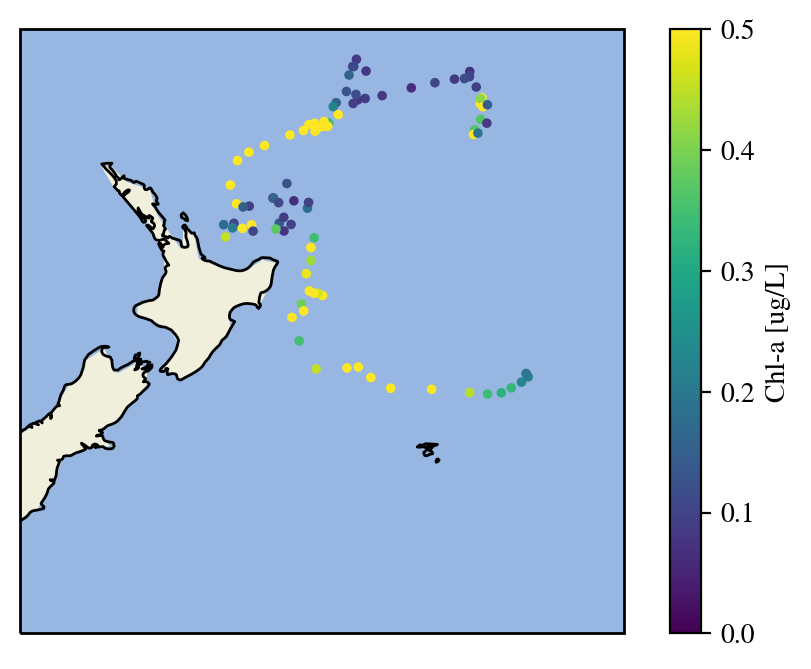

In [17]:
# plot map of bgc stations w/ computed values 

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
plt.scatter(bgc_data.df["Long"] + 180, bgc_data.df["Lat"], 
            c=bgc_data.df["Chl-A"], vmin=0, vmax=0.5, s=6)

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')

plt.colorbar(label="Chl-a [ug/L]")

### HC

p-value: 1.0545750053408705e-10
r-value: 0.7593536152294716


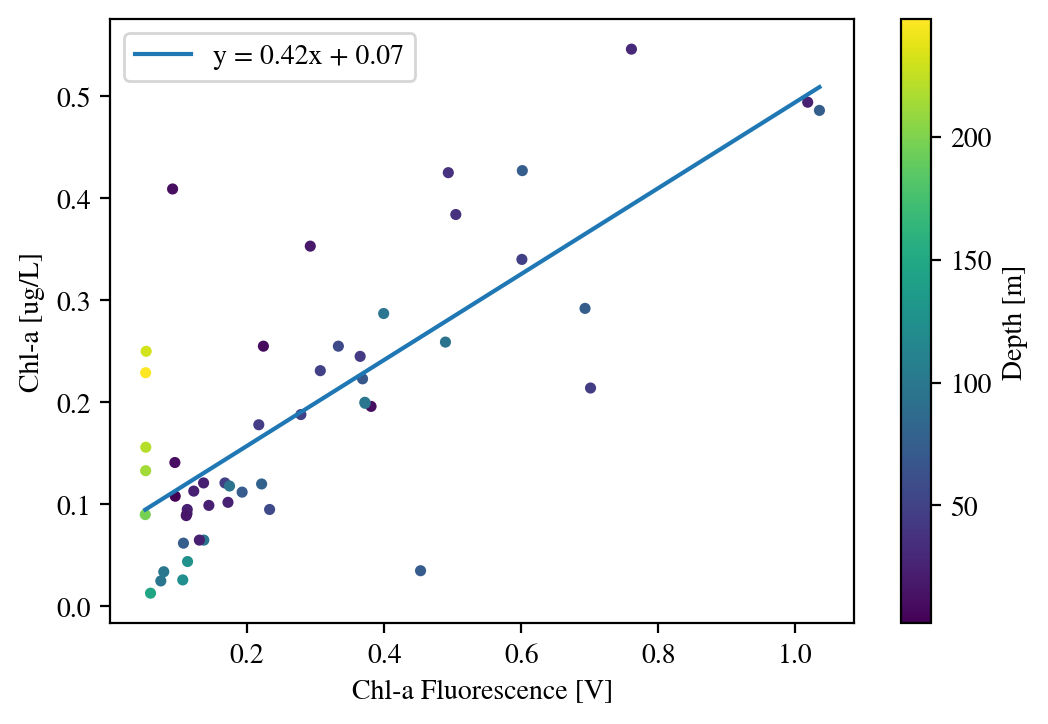

In [18]:
# plot graph of hydrocast calibration & best-fit line

print("p-value: " + str(hc_data._best_fit_line.p_value))
print("r-value: " + str(hc_data._best_fit_line.r_value))
hc_data.visualizeCalibration()

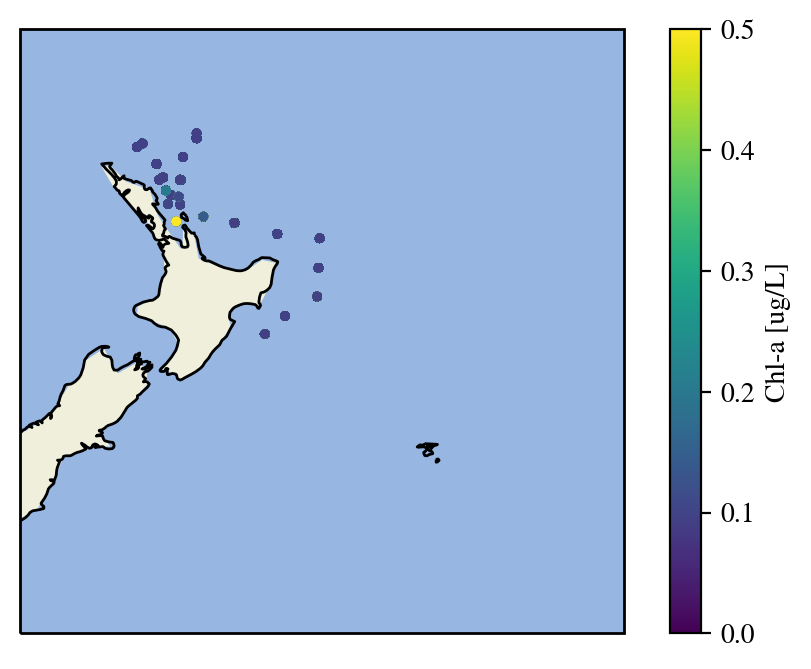

In [19]:
# plot map of hydrocast stations w/ computed values

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
plt.scatter(hc_data.df["Long"] + 180, hc_data.df["Lat"], c=hc_data.df["Chl-A"], vmin=0, vmax=0.5, s=6)

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')

plt.colorbar(label="Chl-a [ug/L]")

### Flow-through


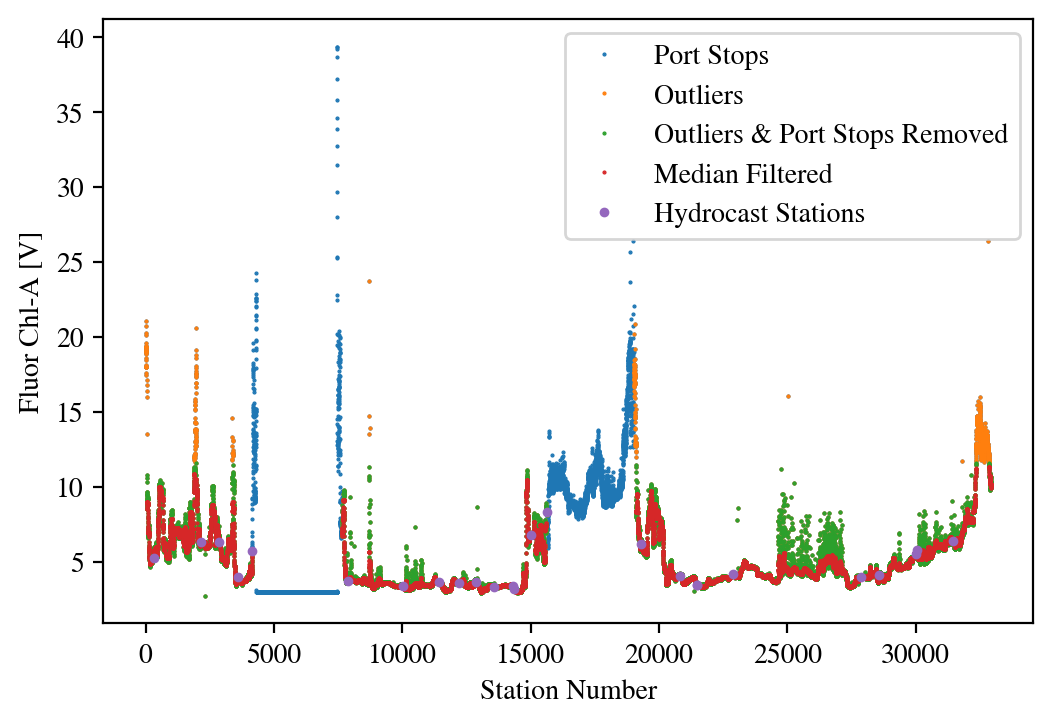

In [20]:
# plot port, outlier, filtered, median filtered, hc stations
plt.plot(ft_data._raw_df["Station Num"],
         ft_data._raw_df["Fluor-Chl-avg-1-min-Value"], 
         '.', markersize=1, label="Port Stops")

plt.plot(ft_data.port_filtered_df["Station Num"],
         ft_data.port_filtered_df["Fluor-Chl-avg-1-min-Value"], 
         '.', markersize=1, label="Outliers")

plt.plot(ft_data.outlier_filtered_df["Station Num"],
         ft_data.outlier_filtered_df["Fluor-Chl-avg-1-min-Value"], 
         '.', markersize=1, label="Outliers & Port Stops Removed")

plt.plot(ft_data.median_filtered_df["Station Num"],
         ft_data.median_filtered_df["Fluor-Chl-avg-1-min-Value"], 
         '.', markersize=1, label="Median Filtered")

plt.plot(ft_data._cal_df["FT Station"],
         ft_data._cal_df["FT Chlorophyll"], 
         '.', markersize=5, label="Hydrocast Stations")

plt.ylabel("Fluor Chl-A [V]")
plt.xlabel("Station Number")
plt.legend()

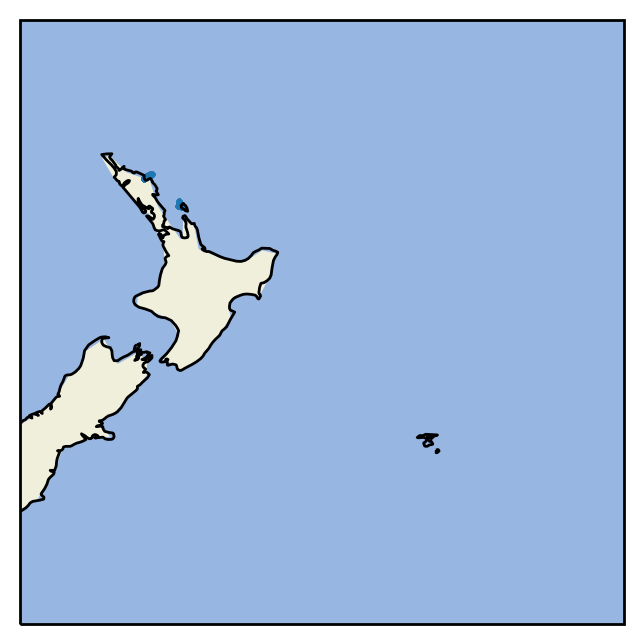

In [21]:
# plot noisy point locations (port stop data)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
plt.scatter(ft_data.port_df["Longitude"] + 180, ft_data.port_df["Latitude"], 
            vmin=0, vmax=1, s=1)

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')

plt.plot(ft_data.port_df["Station Num"],
         ft_data.port_df["Fluor-Chl-avg-1-min-Value"], 
         '.', markersize=2)

# plt.title("Port Stop Datapoints")

Text(0, 0.5, 'Hydrocast Chl-a [ug/L]')

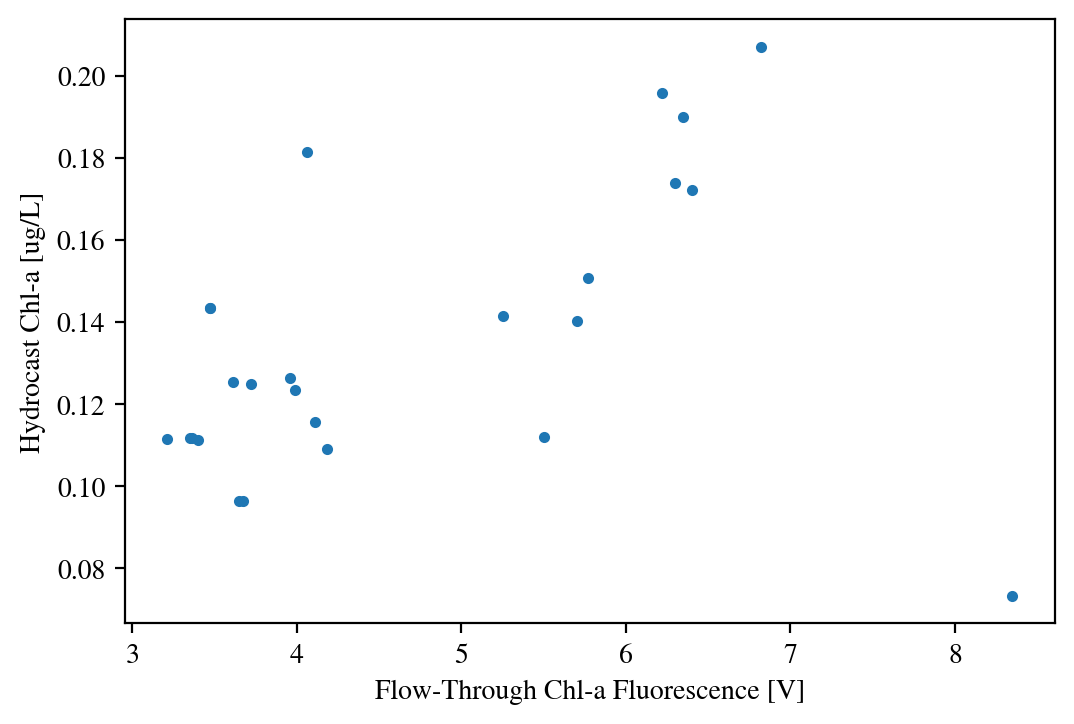

In [22]:
# plot graph of flow-through with all pts
plt.plot(ft_data._cal_df["FT Chlorophyll"],
         ft_data._cal_df["Chl-A"], '.')
plt.xlabel("Flow-Through Chl-a Fluorescence [V]")
plt.ylabel("Hydrocast Chl-a [ug/L]")

p-value: 1.7040145927505336e-05
r-value: 0.7590966099772464


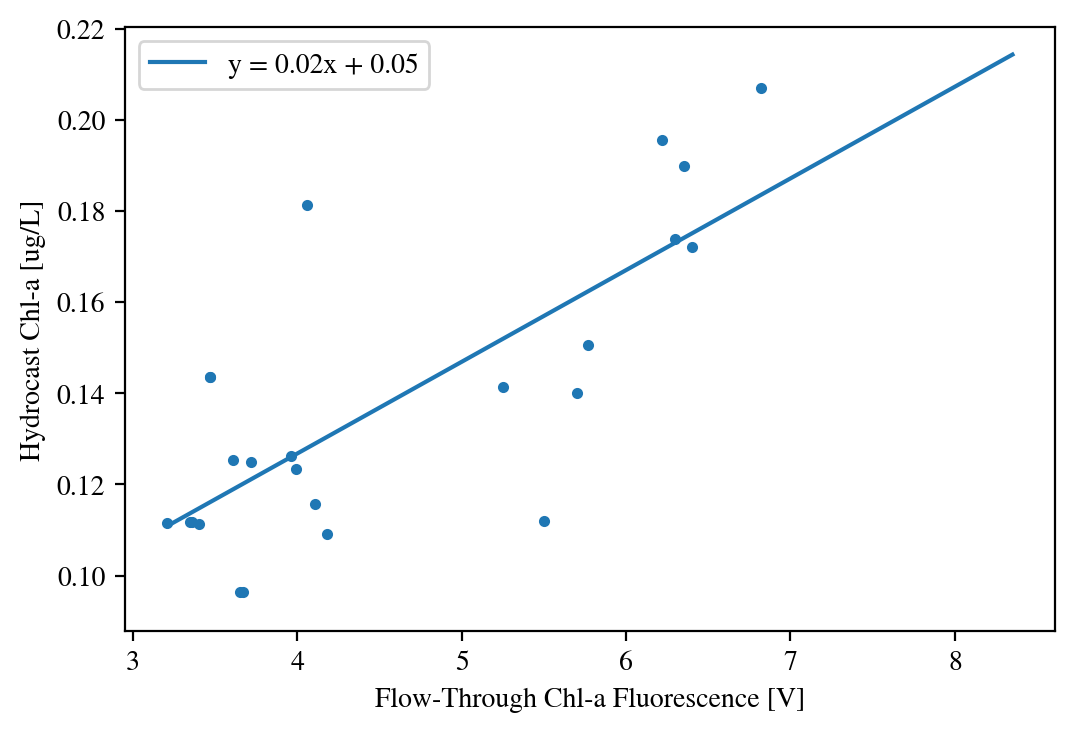

In [23]:
# plot graph of flow-through calibration
print("p-value: " + str(ft_data._best_fit_line.p_value))
print("r-value: " + str(ft_data._best_fit_line.r_value))
ft_data.visualizeCalibration()

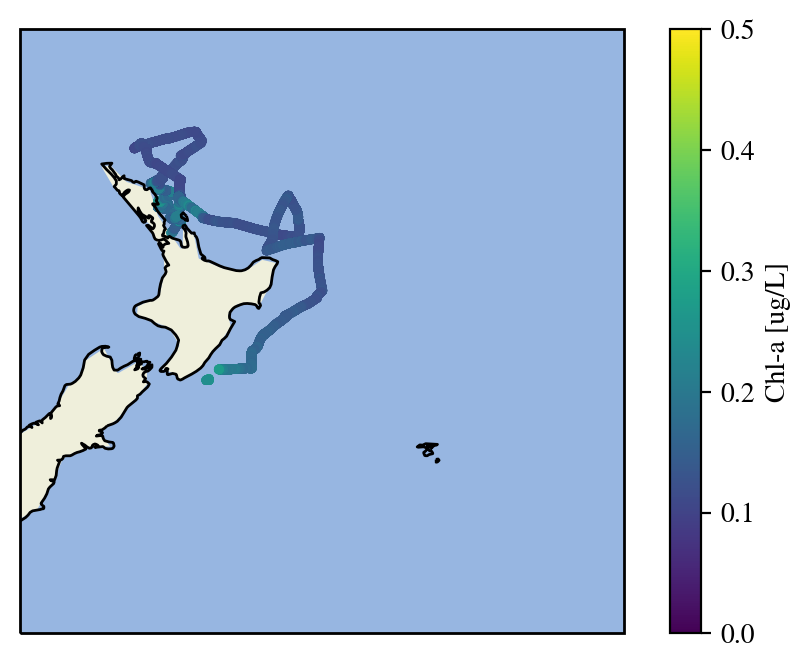

In [24]:
# plot map of flow-through stations w/ computed values 

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
plt.scatter(ft_data.df["Long"] + 180, ft_data.df["Lat"], 
            c=ft_data.df["Chl-A"], vmin=0, vmax=0.5, s=6)

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')

plt.colorbar(label="Chl-a [ug/L]")

### Satellite

In [25]:
# plot 3 samples of satellite data (manually load in 3 files & plot downsampled)

downsample = 10

Text(0.5, -0.1, 'July 4th, 2017 to July 11th, 2017')

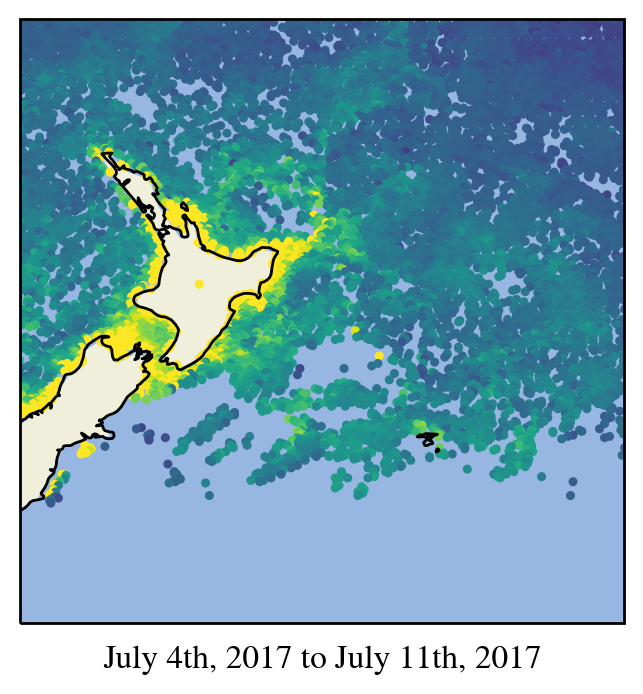

In [26]:
f = "data/satellite-data/autogenerated-csv\\V20171852017192.L3m_8D_SNPP_CHL.x_chlor_a.csv"

num_lines = sum(1 for l in open(f)) # count lines
skip_idx = [x for x in range(1, num_lines) if x % downsample != 0]
single_sat_df = pd.read_csv(f, skiprows=skip_idx)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
plt.scatter(single_sat_df["Longitude"] + 180, single_sat_df["Latitude"],
            c=single_sat_df["Chlorophyll"], vmin=0, vmax=0.5, s=5)

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')

plt.title("July 4th, 2017 to July 11th, 2017", y=-0.1)
# plt.colorbar(label="Chl-A [ug/L]")

Text(0.5, -0.1, 'May 9th, 2018 to May 16th, 2018')

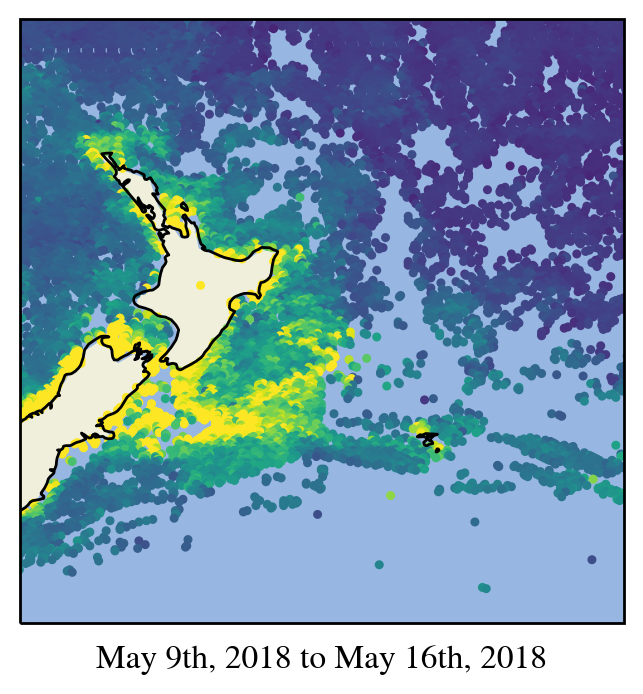

In [27]:
f = "data/satellite-data/autogenerated-csv\\V20181292018136.L3m_8D_SNPP_CHL.x_chlor_a.csv"

num_lines = sum(1 for l in open(f)) # count lines
skip_idx = [x for x in range(1, num_lines) if x % downsample != 0]
single_sat_df = pd.read_csv(f, skiprows=skip_idx)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
plt.scatter(single_sat_df["Longitude"] + 180, single_sat_df["Latitude"],
            c=single_sat_df["Chlorophyll"], vmin=0, vmax=0.5, s=5)

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')

plt.title("May 9th, 2018 to May 16th, 2018", y=-0.1)
# plt.colorbar(label="Chl-A [ug/L]")

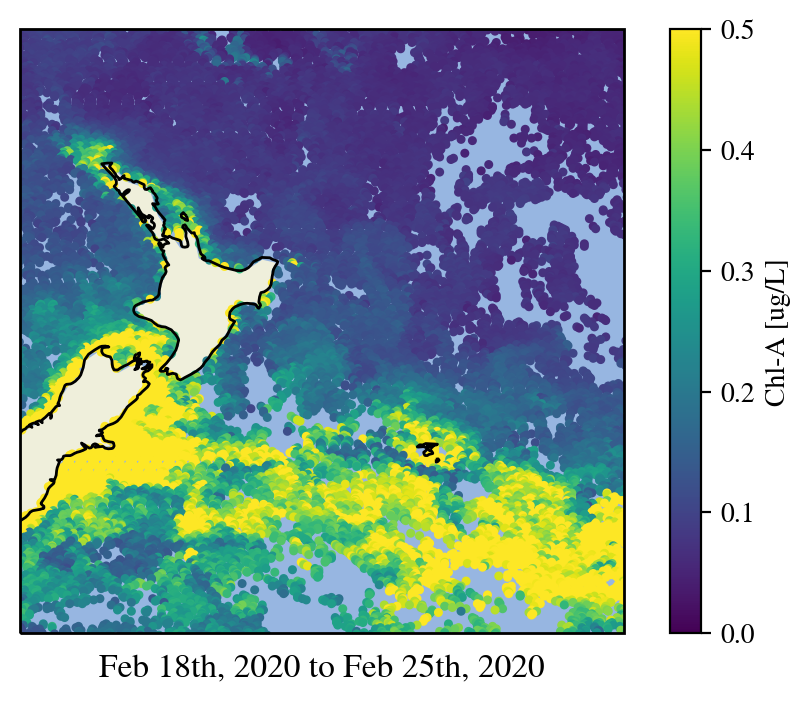

In [28]:
f = "data/satellite-data/autogenerated-csv\\V20200492020056.L3m_8D_SNPP_CHL.x_chlor_a.csv"

num_lines = sum(1 for l in open(f)) # count lines
skip_idx = [x for x in range(1, num_lines) if x % downsample != 0]
single_sat_df = pd.read_csv(f, skiprows=skip_idx)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
plt.scatter(single_sat_df["Longitude"] + 180, single_sat_df["Latitude"],
            c=single_sat_df["Chlorophyll"], vmin=0, vmax=0.5, s=5)

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')

plt.title("Feb 18th, 2020 to Feb 25th, 2020", y=-0.1)
plt.colorbar(label="Chl-A [ug/L]")

# Stats & Comparison

## BGC

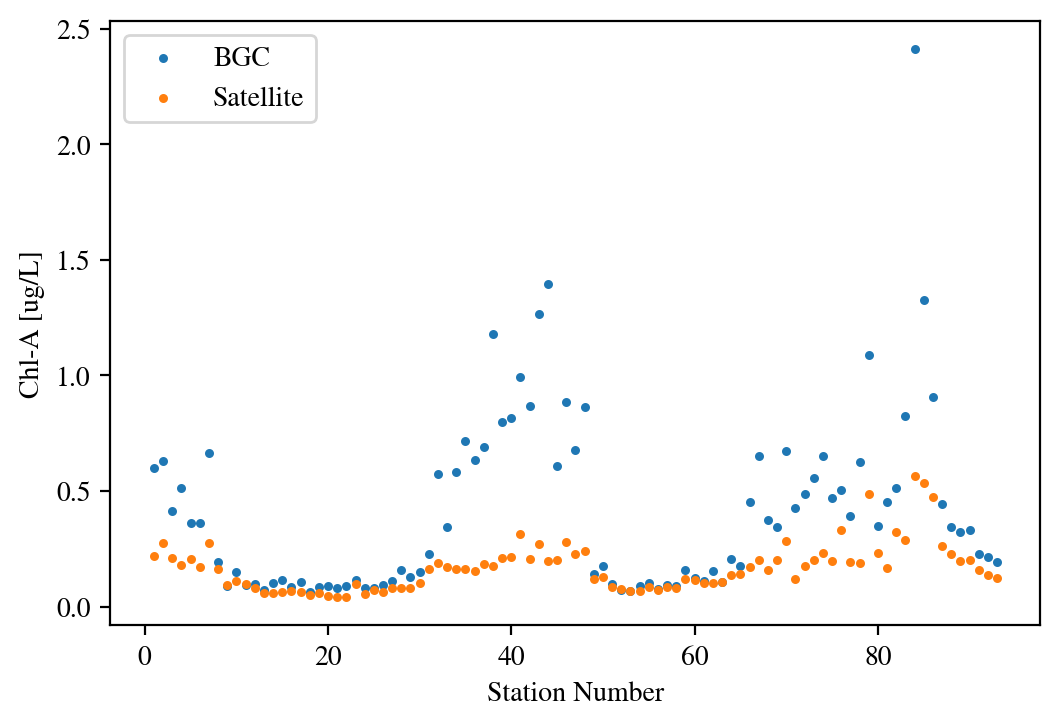

In [270]:
# plot bgc vs sat by station

plt.scatter(compiled_df[compiled_df["Src"]=="BGC"]["Station"],
            compiled_df[compiled_df["Src"]=="BGC"]["Chl-A"], 
            s=5, label="BGC")

plt.scatter(compiled_df[compiled_df["Src"]=="BGC"]["Station"],
            compiled_df[compiled_df["Src"]=="BGC"]["Sat Chl-A"], 
            s=5, label="Satellite")

plt.xlabel("Station Number")
plt.ylabel("Chl-A [ug/L]")
plt.legend()

p-value 0: 3.5410462733602857e-15
r-value 0: 0.8801591496271743
p-value 1: 2.7486626295997237e-07
r-value 1: 0.658211451507514


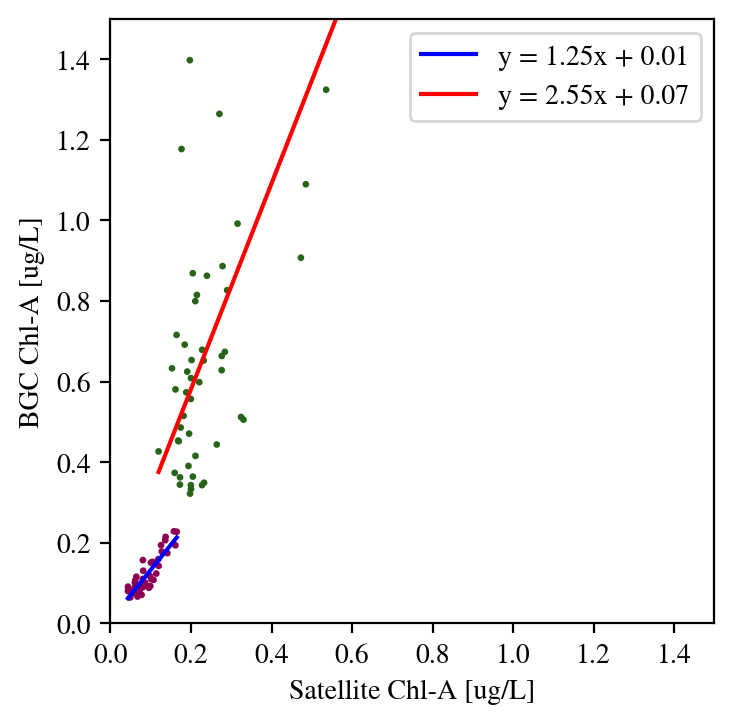

In [271]:
x = bgc_pts["Sat Chl-A"]
y = bgc_pts["Chl-A"]
X = np.array(list(zip(x,y)))

# Cluster data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(X).predict(X)

# Compute and plot best fit lines for cluster 0
x0 = x[labels == 0]
y0 = y[labels == 0]

bgc_sat_line0 = BestFitLine(x0, y0)
print("p-value 0: " + str(bgc_sat_line0.p_value))
print("r-value 0: " + str(bgc_sat_line0.r_value))
eq0= "y = " + str(round(bgc_sat_line0.slope,2)) + \
      "x + " + str(round(bgc_sat_line0.intercept,2))

xp = np.linspace(x0.min(), x0.max(), 100)
plt.plot(xp, bgc_sat_line0.computeY(xp), 'b-', label=eq0)

# Compute and plot best fit lines for cluster 1
x1 = x[labels == 1]
y1 = y[labels == 1]

bgc_sat_line1 = BestFitLine(x1, y1)
print("p-value 1: " + str(bgc_sat_line1.p_value))
print("r-value 1: " + str(bgc_sat_line1.r_value))
eq1 = "y = " + str(round(bgc_sat_line1.slope,2)) + \
      "x + " + str(round(bgc_sat_line1.intercept,2))

xp = np.linspace(x1.min(), x1.max(), 100)
plt.plot(xp, bgc_sat_line1.computeY(xp), 'r-', label=eq1)



# Plot Clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=2, cmap='PiYG', zorder=2)

plt.axis("equal")
plt.xlim([0,1.5])
plt.ylim([0,1.5])

plt.xlabel("Satellite Chl-A [ug/L]")
plt.ylabel("BGC Chl-A [ug/L]")

major_ticks = np.arange(0, 1.6, 0.2)
plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')

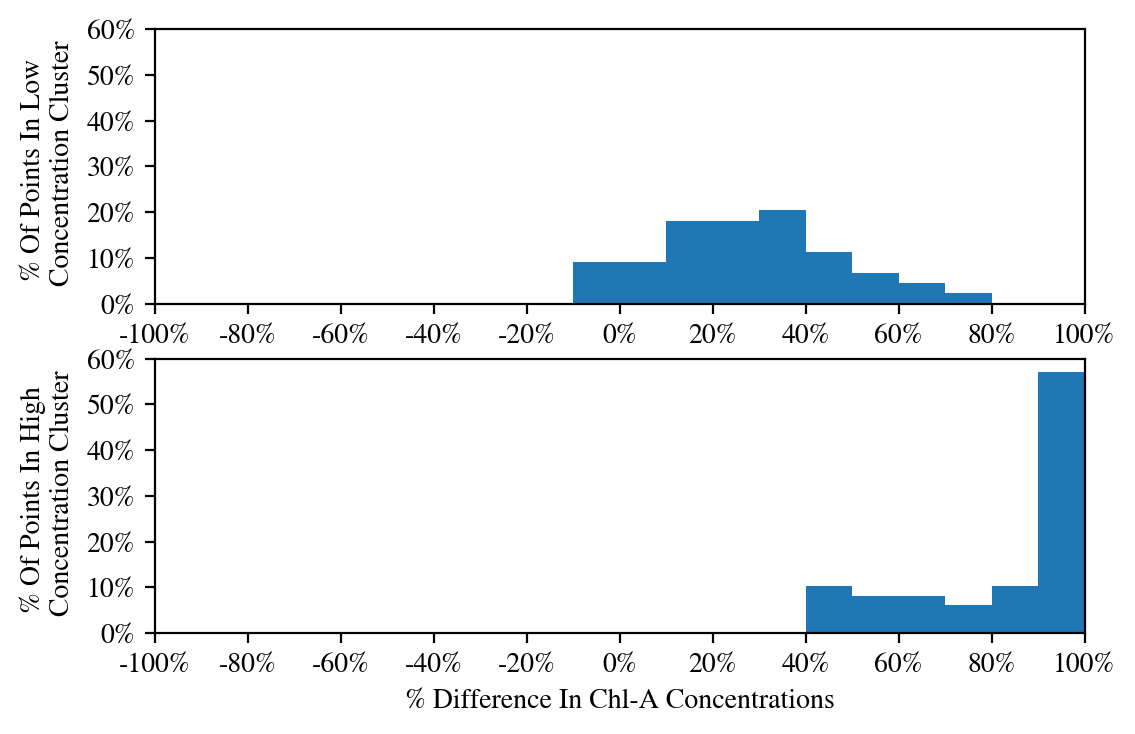

Cluster 1 mean: 27.866006592170876%
Cluster 2 mean: 89.9525458650179%
Overall mean: 60.57826921979994%


In [272]:
data0 = (y0-x0)/((y0+x0)/2)*100
data1 = (y1-x1)/((y1+x1)/2)*100
n_bins = 10

# Include values greater or less than 100 percent in 100 percent bin
bins = np.arange(-100,101,n_bins)
bins[0] = -1000
bins[-1] = 1000

# Create two subplots sharing y axis
fig, (ax0, ax1) = plt.subplots(2, sharey=True)

ax0.hist(data0, weights=np.ones(len(data0)) / len(data0),
         bins=bins)
ax0.set(ylabel='% Of Points In Low \n Concentration Cluster')
ax0.yaxis.set_major_formatter(PercentFormatter(1))
ax0.xaxis.set_major_formatter(PercentFormatter(100))
ax0.set_xlim([-100,100])

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1),
         bins=bins)
ax1.set(xlabel='% Difference In Chl-A Concentrations',
        ylabel='% Of Points In High \n Concentration Cluster')
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.xaxis.set_major_formatter(PercentFormatter(100))
ax1.set_xlim([-100,100])

# Adjust ticks
x_ticks = np.arange(-100, 101, 20) 
y_ticks = np.arange(0, 0.61, 0.1)
ax0.set_xticks(x_ticks)
ax0.set_yticks(y_ticks)
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

plt.show()

print("Cluster 1 mean: " + str(data0.mean()) + "%")
print("Cluster 2 mean: " + str(data1.mean()) + "%")
print("Overall mean: " + str(np.append(data0, data1).mean()) + "%")

## Flow-Through

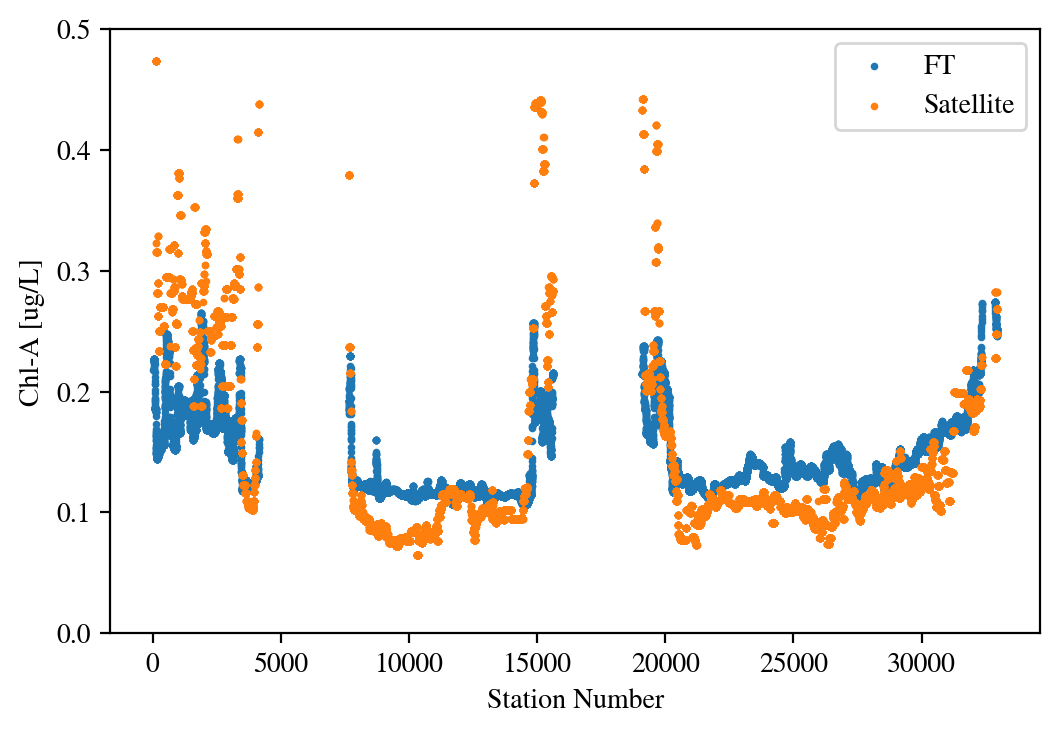

In [273]:
# plot ft vs sat by station

plt.scatter(compiled_df[compiled_df["Src"]=="FT"]["Station"],
            compiled_df[compiled_df["Src"]=="FT"]["Chl-A"], 
            s=3, label="FT")

plt.scatter(compiled_df[compiled_df["Src"]=="FT"]["Station"],
            compiled_df[compiled_df["Src"]=="FT"]["Sat Chl-A"], 
            s=3, label="Satellite")

plt.xlabel("Station Number")
plt.ylabel("Chl-A [ug/L]")
plt.ylim([0,0.5])
plt.legend()

p-value 0: 0.0
r-value 0: 0.359440620654013
p-value 1: 7.635740660613166e-101
r-value 1: 0.23501051875715054


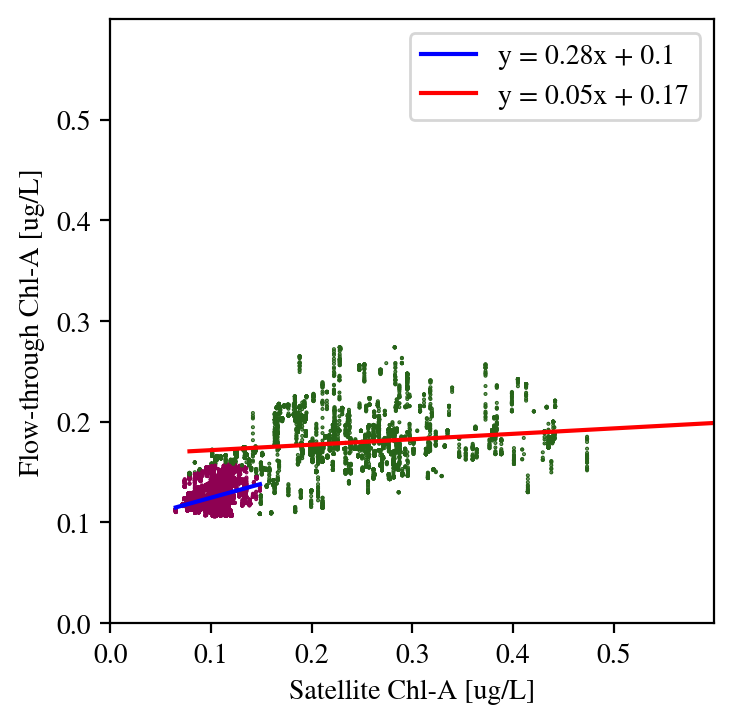

In [274]:
x = ft_pts["Sat Chl-A"]
y = ft_pts["Chl-A"]
X = np.array(list(zip(x,y)))

# Cluster data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(X).predict(X)

# Compute and plot best fit lines for cluster 0
x0 = x[labels == 0]
y0 = y[labels == 0]

ft_sat_line0 = BestFitLine(x0, y0)
print("p-value 0: " + str(ft_sat_line0.p_value))
print("r-value 0: " + str(ft_sat_line0.r_value))
eq0= "y = " + str(round(ft_sat_line0.slope,2)) + \
      "x + " + str(round(ft_sat_line0.intercept,2))

xp = np.linspace(x0.min(), x0.max(), 100)
plt.plot(xp, ft_sat_line0.computeY(xp), 'b-', label=eq0)

# Compute and plot best fit lines for cluster 1
x1 = x[labels == 1]
y1 = y[labels == 1]

ft_sat_line1 = BestFitLine(x1, y1)
print("p-value 1: " + str(ft_sat_line1.p_value))
print("r-value 1: " + str(ft_sat_line1.r_value))
eq1 = "y = " + str(round(ft_sat_line1.slope,2)) + \
      "x + " + str(round(ft_sat_line1.intercept,2))

xp = np.linspace(x1.min(), x1.max(), 100)
plt.plot(xp, ft_sat_line1.computeY(xp), 'r-', label=eq1)



# Plot Clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=0.2, cmap='PiYG', zorder=2)

plt.axis("equal")
plt.xlim([0,0.6])
plt.ylim([0,0.6])

plt.xlabel("Satellite Chl-A [ug/L]")
plt.ylabel("Flow-through Chl-A [ug/L]")

major_ticks = np.arange(0, 0.6, 0.1)
plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')

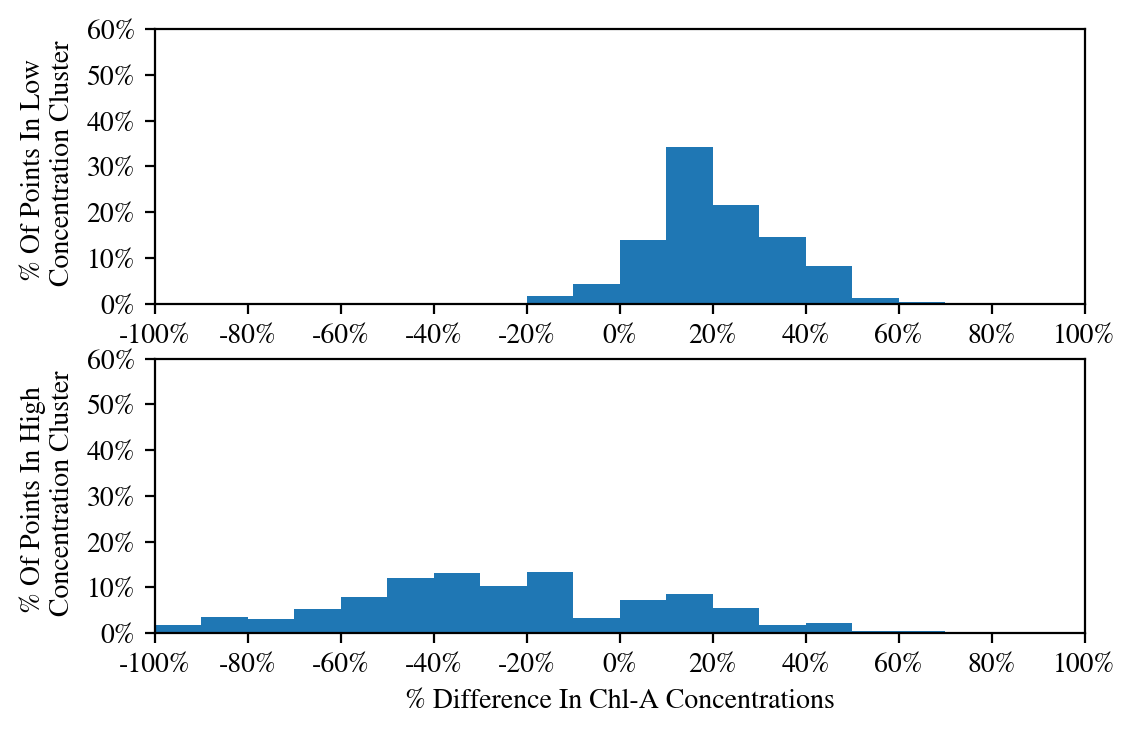

Cluster 1 mean: 20.607557522180077%
Cluster 2 mean: -24.817786016936%
Overall mean: 6.251570199904924%


In [276]:
data0 = (y0-x0)/((y0+x0)/2)*100
data1 = (y1-x1)/((y1+x1)/2)*100
n_bins = 10

# Include values greater or less than 100 percent in 100 percent bin
bins = np.arange(-100,101,n_bins)
bins[0] = -1000
bins[-1] = 1000

# Create two subplots sharing y axis
fig, (ax0, ax1) = plt.subplots(2, sharey=True)

ax0.hist(data0, weights=np.ones(len(data0)) / len(data0),
         bins=bins)
ax0.set(ylabel='% Of Points In Low \n Concentration Cluster')
ax0.yaxis.set_major_formatter(PercentFormatter(1))
ax0.xaxis.set_major_formatter(PercentFormatter(100))
ax0.set_xlim([-100,100])

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1),
         bins=bins)
ax1.set(xlabel='% Difference In Chl-A Concentrations',
        ylabel='% Of Points In High \n Concentration Cluster')
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.xaxis.set_major_formatter(PercentFormatter(100))
ax1.set_xlim([-100,100])

# Adjust ticks
x_ticks = np.arange(-100, 101, 20) 
y_ticks = np.arange(0, 0.61, 0.1)
ax0.set_xticks(x_ticks)
ax0.set_yticks(y_ticks)
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

plt.show()

print("Cluster 1 mean: " + str(data0.mean()) + "%")
print("Cluster 2 mean: " + str(data1.mean()) + "%")
print("Overall mean: " + str(np.append(data0, data1).mean()) + "%")

# Sandbox

In [156]:
np.array(x1-y1).mean()

0.06804118927400347

In [158]:
np.array(x0-y0).mean()

-0.022841449672119242

In [186]:
np.arange(-100,100,10)

array([-100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,
         10,   20,   30,   40,   50,   60,   70,   80,   90])

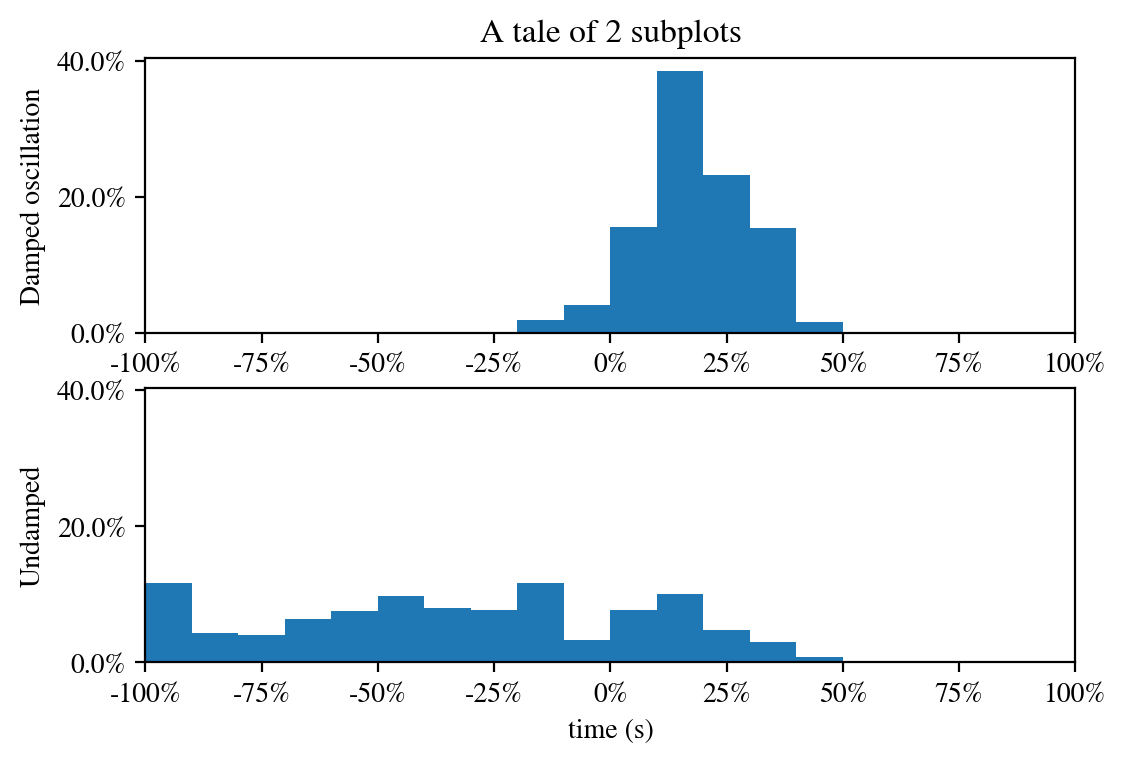

In [210]:
data0 = (y0-x0)/y0*100
data1 = (y1-x1)/y1*100
n_bins = 10

bins = np.arange(-100,101,n_bins)
bins[0] = -1000
bins[-1] = 1000


# plt.hist(data, weights=np.ones(len(data)) / len(data), bins=np.arange(-100,101,bins))
# # plt.xlim([-100,100])
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))



# Create two subplots sharing y axis
fig, (ax0, ax1) = plt.subplots(2, sharey=True)

ax0.hist(data0, weights=np.ones(len(data0)) / len(data0),
         bins=bins)
ax0.set(title='A tale of 2 subplots', ylabel='Damped oscillation')
ax0.yaxis.set_major_formatter(PercentFormatter(1))
ax0.xaxis.set_major_formatter(PercentFormatter(100))
ax0.set_xlim([-100,100])

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1),
         bins=bins)
ax1.set(xlabel='time (s)', ylabel='Undamped')
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.xaxis.set_major_formatter(PercentFormatter(100))
ax1.set_xlim([-100,100])

plt.show()

(array([  3.,   2.,   1.,   7.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   3.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   2.,   3.,
          1.,   1.,   0.,   2.,   1.,   1.,   1.,   1.,  13.,  10.,  15.,
          2.,   0.,   0.,   0.,   0.,   8.,  11.,   7.,   2.,   5.,  10.,
          4.,   4.,   4.,   7.,  16.,  60., 177.,  47.,  54.,  74.,  81.,
         90., 105., 127., 239., 212., 241., 394., 346., 464., 561., 381.,
        412., 445., 666., 400., 171., 413., 529., 483., 329., 149., 138.,
         53.]),
 array([-6.31635241e+02, -6.24844658e+02, -6.18054076e+02, -6.11263493e+02,
        -6.04472910e+02, -5.97682327e+02, -5.90891745e+02, -5.84101162e+02,
        -5.77310579e+02, -5.70519996e+02, -5.63729413e+02, -5.56938831e+02,
        -5.50148248e+02, -5.43357665e+02, -5.36567082e+02, -5.29776500e+02,
        -5.229

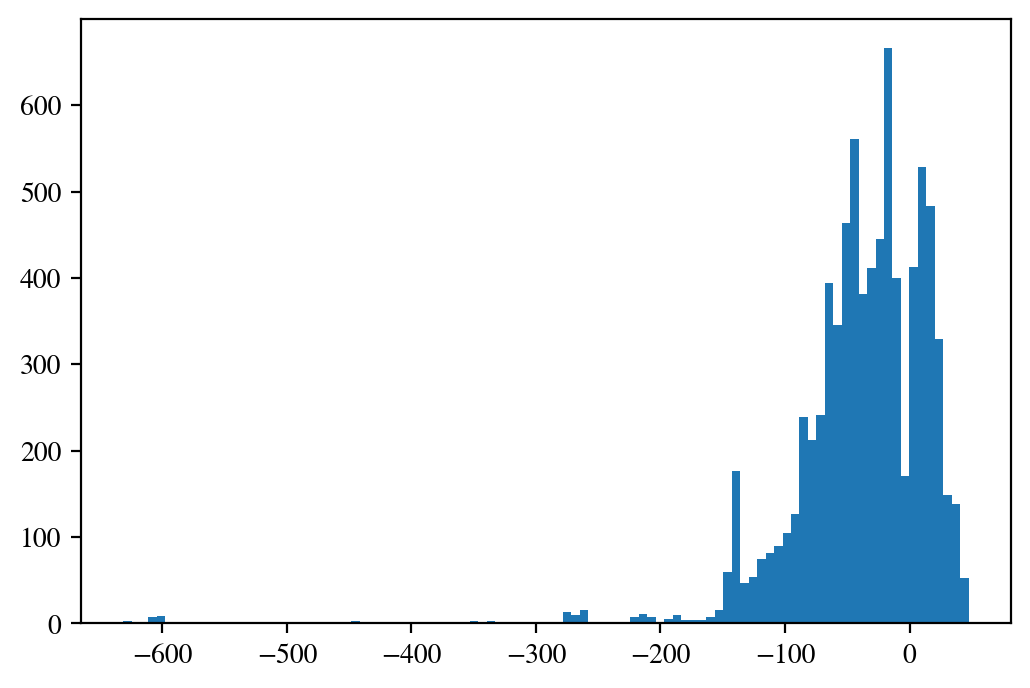

In [166]:
data = (y1-x1)/y1*100
n_bins = 100

plt.hist(data, bins=n_bins)
# plt.xlim([-100,100])

p-value: 0.0
r-value: 0.6740938409619576


(0, 0.6)

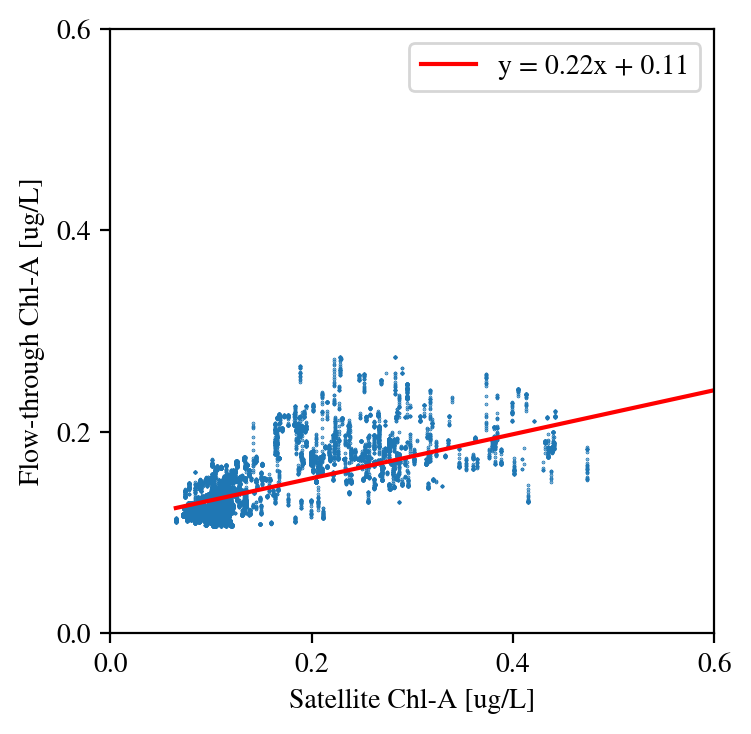

In [43]:


# plot ft vs sat directly

ft_pts = compiled_df[compiled_df["Src"]=="FT"]

# x = ft_pts["Sat Chl-A"] < 0.2 
# y = ft_pts["Chl-A"]

# x = ft_pts["Sat Chl-A"]
# y = ft_pts["Chl-A"]




ft_sat_line = BestFitLine(x, y)
print("p-value: " + str(ft_sat_line.p_value))
print("r-value: " + str(ft_sat_line.r_value))
eq = "y = " + str(round(ft_sat_line.slope,2)) + \
     "x + " + str(round(ft_sat_line.intercept,2))

xp = np.linspace(x.min(), x.max(), 100)
plt.plot(xp, ft_sat_line.computeY(xp), 'r-', label=eq)

plt.scatter(x, y, s=0.1)

plt.axis("equal")


plt.xlabel("Satellite Chl-A [ug/L]")
plt.ylabel("Flow-through Chl-A [ug/L]")

major_ticks = np.arange(0, 1.7, 0.2)
plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([0,0.6])
plt.ylim([0,0.6])

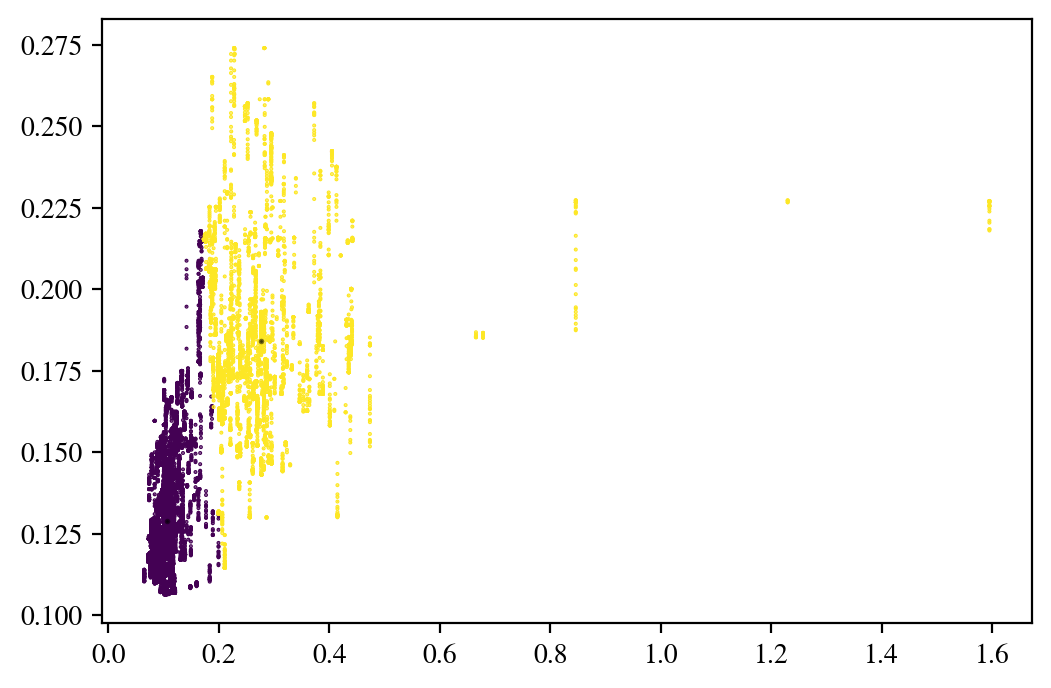

In [63]:
x = ft_pts["Sat Chl-A"]
y = ft_pts["Chl-A"]

from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

# X, y_true = make_blobs(n_samples=300, centers=4,
#                        cluster_std=0.60, random_state=0)
X = np.array(list(zip(x,y)))
# plt.scatter(X[:, 0], X[:, 1], s=50);

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)
                          
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=0.2, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=1, alpha=0.5);

(0, 0.4)

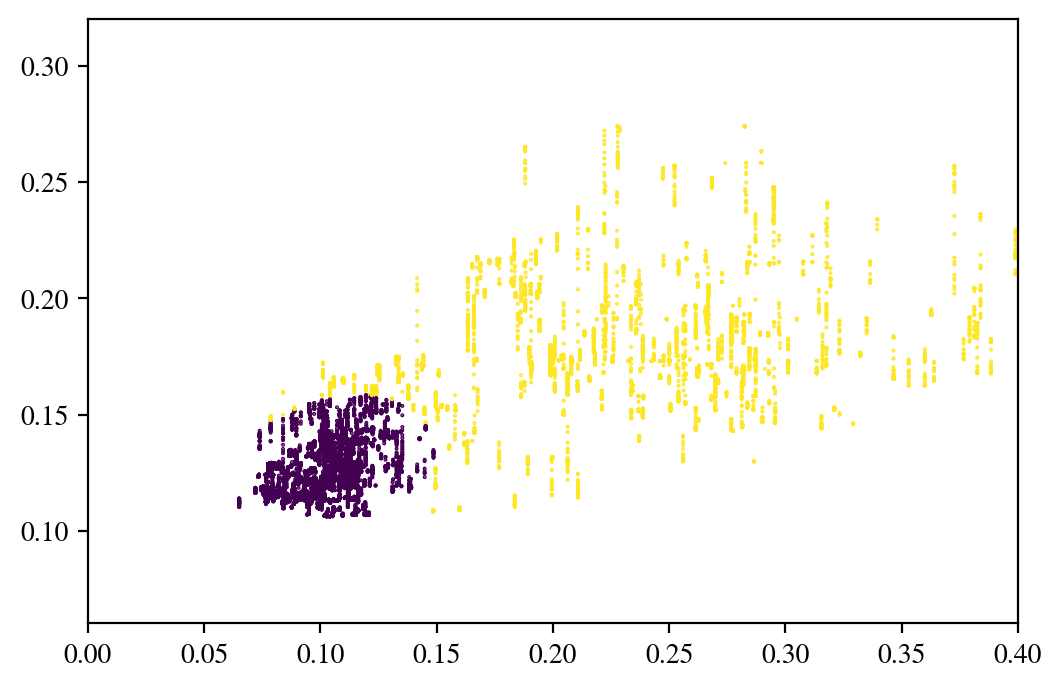

In [115]:
x = ft_pts["Sat Chl-A"]
y = ft_pts["Chl-A"]
X = np.array(list(zip(x,y)))

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
plot_gmm(gmm, X)
plt.xlim([0,0.4])

In [112]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=0.2, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
#     for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
#         draw_ellipse(pos, covar, alpha=w * w_factor)

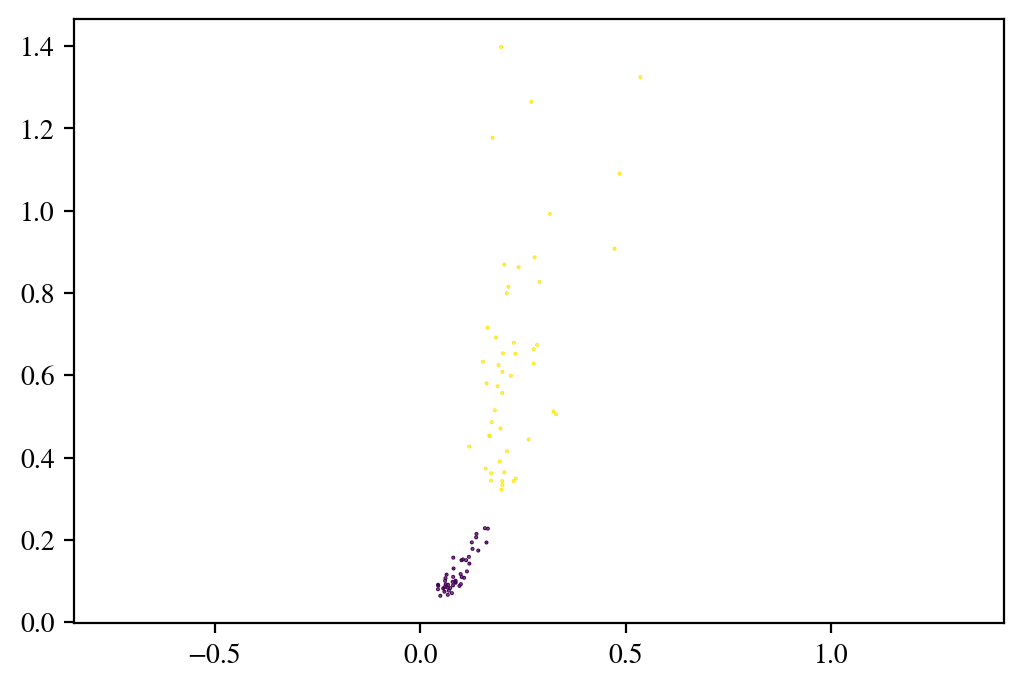

In [113]:
X = np.array(list(zip(x,y)))
x = bgc_pts[bgc_pts["Chl-A"] < 1.6]["Sat Chl-A"]
y = bgc_pts[bgc_pts["Chl-A"] < 1.6]["Chl-A"]

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
plot_gmm(gmm, X)

(0.01787356914053201,
 0.5609400708594682,
 -0.004264227250505348,
 1.4659852272505056)

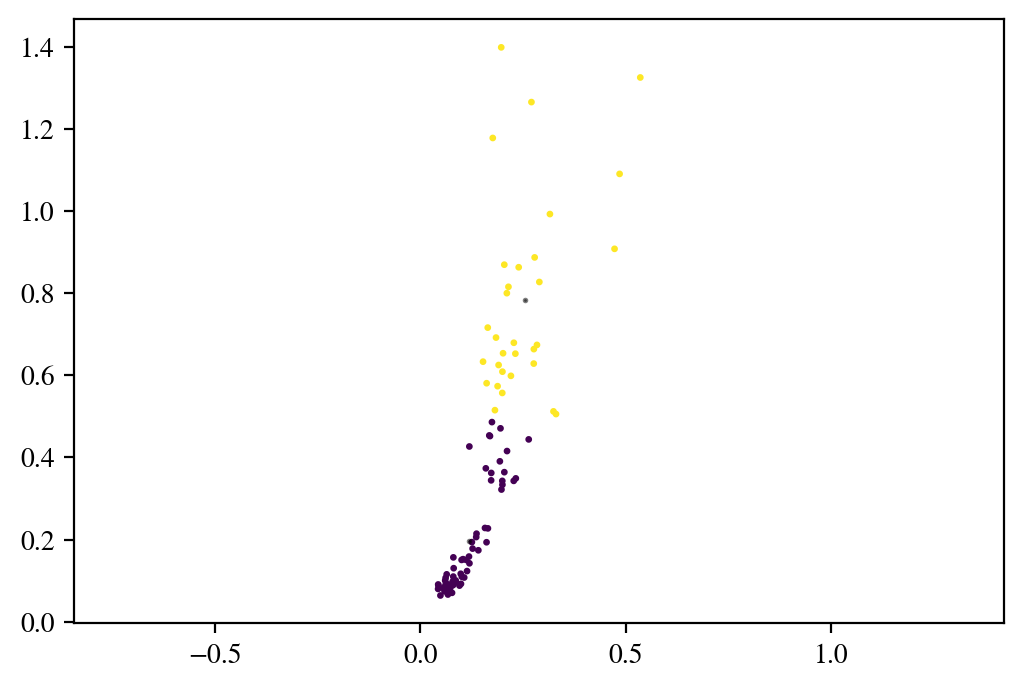

In [84]:


from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

# X, y_true = make_blobs(n_samples=300, centers=4,
#                        cluster_std=0.60, random_state=0)
X = np.array(list(zip(x,y)))
# plt.scatter(X[:, 0], X[:, 1], s=50);

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)
                          
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=2)#, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=1, alpha=0.5);
plt.axis("equal")

(0.01787356914053201,
 0.5609400708594682,
 -0.004264227250505348,
 1.4659852272505056)

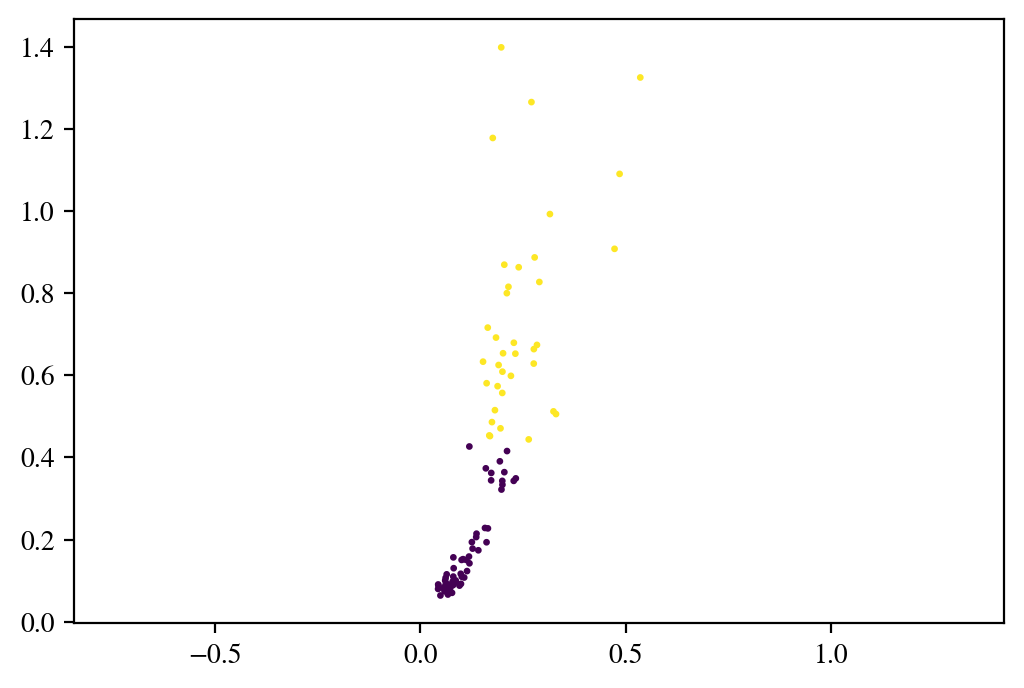

In [85]:
x = bgc_pts[bgc_pts["Chl-A"] < 1.6]["Sat Chl-A"]
y = bgc_pts[bgc_pts["Chl-A"] < 1.6]["Chl-A"]

from sklearn.cluster import SpectralClustering
from sklearn.datasets.samples_generator import make_blobs

# X, y_true = make_blobs(n_samples=300, centers=4,
#                        cluster_std=0.60, random_state=0)
X = np.array(list(zip(x,y)))
# plt.scatter(X[:, 0], X[:, 1], s=50);

clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=1).fit(X)
# kmeans.fit(X)

# y_kmeans = kmeans.predict(X)
                          
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=2)#, cmap='viridis')

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=1, alpha=0.5);
plt.axis("equal")

In [48]:
X

array([[ 8.36856841e-01,  2.13635938e+00],
       [-1.41365810e+00,  7.40962324e+00],
       [ 1.15521298e+00,  5.09961887e+00],
       [-1.01861632e+00,  7.81491465e+00],
       [ 1.27135141e+00,  1.89254207e+00],
       [ 3.43761754e+00,  2.61654166e-01],
       [-1.80822253e+00,  1.59701749e+00],
       [ 1.41372442e+00,  4.38117707e+00],
       [-2.04932168e-01,  8.43209665e+00],
       [-7.11099611e-01,  8.66043846e+00],
       [-1.71237268e+00,  2.77780226e+00],
       [-2.67000792e+00,  8.35389140e+00],
       [ 1.24258802e+00,  4.50399192e+00],
       [-2.22783649e+00,  6.89479938e+00],
       [ 1.45513831e+00, -2.91989981e-02],
       [ 4.53791789e-01,  3.95647753e+00],
       [ 1.06923853e+00,  4.53068484e+00],
       [ 2.56936589e+00,  5.07048304e-01],
       [-1.06690610e+00,  3.13165795e+00],
       [-1.07859101e+00,  2.20451529e+00],
       [ 2.71506328e+00,  1.29082190e+00],
       [ 1.77710994e+00,  1.18655254e+00],
       [ 7.34363910e-01,  5.03725437e+00],
       [-1.

In [56]:
np.array(list(zip(x,y)))


array([[1.5949008 , 0.21799125],
       [1.5949008 , 0.21839398],
       [1.5949008 , 0.21839398],
       ...,
       [0.28277668, 0.24698792],
       [0.28277668, 0.24618245],
       [0.28277668, 0.24598109]])

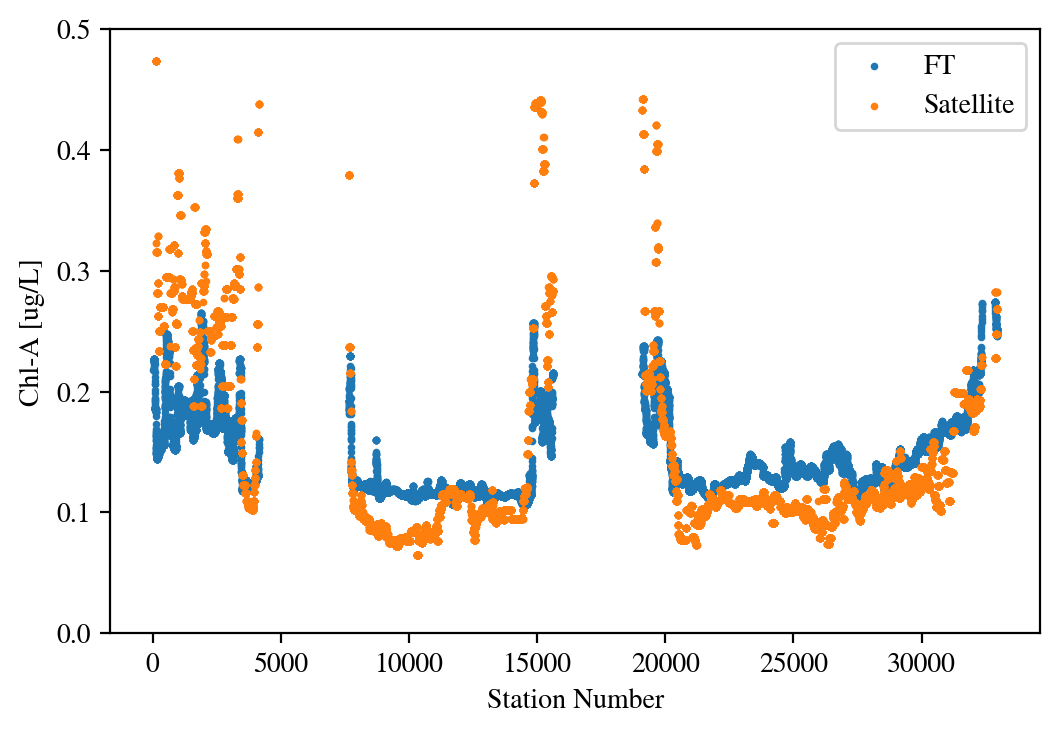

In [32]:
# plot ft vs sat by station

plt.scatter(compiled_df[compiled_df["Src"]=="FT"]["Station"],
            compiled_df[compiled_df["Src"]=="FT"]["Chl-A"], 
            s=3, label="FT")

plt.scatter(compiled_df[compiled_df["Src"]=="FT"]["Station"],
            compiled_df[compiled_df["Src"]=="FT"]["Sat Chl-A"], 
            s=3, label="Satellite")

plt.xlabel("Station Number")
plt.ylabel("Chl-A [ug/L]")
plt.ylim([0,0.5])
plt.legend()